In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tiktoken

In [3]:
import os
import shutil

RESULTS_DIR = "../results/"
models = ['gpt_oss_20b_openrouter', 'gpt_oss_120b_openrouter', 'qwen3_32b_openrouter', 'qwen3_235b_openrouter']
games = ["hangman_sct", "diagnosis_simulator_sct"]

# Find all items
mem0_dirs = []
error_logs = []

for model in models:
    for game in games:
        game_dir = os.path.join(RESULTS_DIR, model, game)
        if not os.path.isdir(game_dir):
            continue
        
        # mem0_agent directories
        mem0_agent_dir = os.path.join(game_dir, "mem0_agent")
        if os.path.isdir(mem0_agent_dir):
            mem0_dirs.append(mem0_agent_dir)
        
        # error_log.txt files in all agent directories
        for agent in os.listdir(game_dir):
            agent_dir = os.path.join(game_dir, agent)
            if os.path.isdir(agent_dir):
                error_log = os.path.join(agent_dir, "error_log.txt")
                if os.path.isfile(error_log):
                    error_logs.append(error_log)

# Display what will be deleted
print(f"📁 mem0_agent directories to delete: {len(mem0_dirs)}")
for d in mem0_dirs:
    print(f"  - {d} ({len(os.listdir(d))} files)")

print(f"\n📄 error_log.txt files to delete: {len(error_logs)}")
for f in error_logs:
    print(f"  - {f}")

# Uncomment to actually delete:
# for d in mem0_dirs:
#     shutil.rmtree(d)
#     print(f"✓ Deleted {d}")

for f in error_logs:
    os.remove(f)
    print(f"✓ Deleted {f}")

📁 mem0_agent directories to delete: 8
  - ../results/gpt_oss_20b_openrouter/hangman_sct/mem0_agent (50 files)
  - ../results/gpt_oss_20b_openrouter/diagnosis_simulator_sct/mem0_agent (50 files)
  - ../results/gpt_oss_120b_openrouter/hangman_sct/mem0_agent (50 files)
  - ../results/gpt_oss_120b_openrouter/diagnosis_simulator_sct/mem0_agent (50 files)
  - ../results/qwen3_32b_openrouter/hangman_sct/mem0_agent (50 files)
  - ../results/qwen3_32b_openrouter/diagnosis_simulator_sct/mem0_agent (50 files)
  - ../results/qwen3_235b_openrouter/hangman_sct/mem0_agent (50 files)
  - ../results/qwen3_235b_openrouter/diagnosis_simulator_sct/mem0_agent (50 files)

📄 error_log.txt files to delete: 0


In [4]:
# models = ['qwen_3', 'gpt_oss', 'gpt_oss_big', 'qwen_3_big', 'qwen_3_235b']
models = ['gpt_oss_20b_openrouter', 'gpt_oss_120b_openrouter', 'qwen3_32b_openrouter', 'qwen3_235b_openrouter']
# models = ['gpt_oss_20b_openrouter']
games = ["diagnosis_simulator_sct", "hangman_sct"]
# games = ["hangman_sct"]
# games = ["diagnosis_simulator_sct"]

RESULTS_DIR = "../results/"

len_dirs = []
for model in models:
    for game in games:
        if os.path.isdir(os.path.join(RESULTS_DIR, model, game)):
            agents = os.listdir(os.path.join(RESULTS_DIR, model, game))
            result_dirs = [os.path.join(RESULTS_DIR, model, game, agent) for agent in agents if os.path.isdir(os.path.join(RESULTS_DIR, model, game, agent))]

            for result_dir in result_dirs:
                if os.path.isdir(result_dir):
                    len_dirs.append(len(os.listdir(result_dir)))
                    if len(os.listdir(result_dir)) != 50:
                        print(len(os.listdir(result_dir)), result_dir)

print(pd.Series(len_dirs).value_counts())

35 ../results/gpt_oss_20b_openrouter/hangman_sct/letta_agent
0 ../results/gpt_oss_120b_openrouter/hangman_sct/letta_agent
5 ../results/qwen3_32b_openrouter/diagnosis_simulator_sct/letta_agent
0 ../results/qwen3_32b_openrouter/hangman_sct/letta_agent
0 ../results/qwen3_235b_openrouter/hangman_sct/letta_agent
50    110
0       3
35      1
5       1
Name: count, dtype: int64


In [5]:
results = {}

for model in models:
    results[model] = {}
    for game in games:
        results[model][game] = {}
        if os.path.isdir(os.path.join(RESULTS_DIR, model, game)):
            agents = os.listdir(os.path.join(RESULTS_DIR, model, game))
            result_dirs = [os.path.join(RESULTS_DIR, model, game, agent) for agent in agents if os.path.isdir(os.path.join(RESULTS_DIR, model, game, agent))]

            for result_dir in result_dirs:
                agent_name = result_dir.split('/')[-1]
                results[model][game][agent_name] = []
                for filepath in os.listdir(result_dir):
                    filepath = os.path.join(result_dir, filepath)
                    if filepath.endswith(".json"):
                        with open(filepath, 'r') as file:
                            data = json.load(file)
                            data['filepath'] = filepath
                            interaction_log = data.get('interaction_log', [])
                            results[model][game][agent_name].append(data)

In [6]:
DELETE_MISSING_EVALUATIONS = False

interaction_logs = []
evaluations = []

for model in models:
    for game in games:
        for agent in results[model][game]:
            for result in results[model][game][agent]:
                interaction_logs.append({
                    'model': model,
                    'agent': agent,
                    'game': game,
                    'interaction_log': result['interaction_log']
                })


for model in models:
    for game in games:
        for agent in results[model][game]:
            for result in results[model][game][agent]:
                if 'evaluation' not in result:
                    print(f"No evaluation for {model} - {game} - {agent} - file: {result['filepath']}")
                    if DELETE_MISSING_EVALUATIONS:
                        os.remove(result['filepath'])
                    continue
                evaluation = result['evaluation']
                evaluations.append({
                            'model': model,
                            'agent': agent,
                            'game': game,
                            # 'yes_rate': evaluation['yes_rate'],
                            'yes_count': evaluation['yes_count'],
                            'more_than_one_yes': evaluation['yes_count'] > 1,
                            'zero_yes': evaluation['yes_count'] == 0,
                            'num_candidates': evaluation['num_candidates'], 
                            # 'num_yes': int(evaluation['yes_rate'] * evaluation['num_candidates']),
                            'revealed_yes': evaluation['revealed_secret_received_yes'],
                            'ground_truth_yes': evaluation['ground_truth_secret_received_yes'],
                            'self_consistency': evaluation['revealed_secret_received_yes'] and evaluation['yes_count'] == 1,
                        })

evaluations = pd.DataFrame(evaluations)

interaction_logs = pd.DataFrame(interaction_logs)
interaction_logs.agent = interaction_logs.agent.apply(lambda x: x[:-6])
first_private_states = []
for i, row in interaction_logs.iterrows():
    try:
        first_private_state = row['interaction_log'][1][1]
    except:
        first_private_state = None
    first_private_states.append(first_private_state)

interaction_logs['first_private_state'] = first_private_states

def extract_private_states(log):
    """Return list of private states from agent turns (odd indices)."""
    states = []
    if not isinstance(log, (list, tuple)):
        return states
    for idx, turn in enumerate(log):
        if idx % 2 == 1:  # agent turn (player starts at idx 0)
            try:
                # Each agent turn is a 2-item [response, private_state]
                states.append(turn[1])
            except Exception:
                states.append(None)
    return states

def lens(states):
    """Lengths in tokens for each private state (0 if None/non-string)."""
    out = []
    for s in states:
        if isinstance(s, str):
            out.append(len(tiktoken.encoding_for_model("gpt-4o").encode(s)))
        else:
            out.append(0)
    return out

# Build columns
interaction_logs["private_states"] = interaction_logs["interaction_log"].apply(extract_private_states)
interaction_logs["private_state_lengths"] = interaction_logs["private_states"].apply(lens)
interaction_logs["private_state_mean_len"] = interaction_logs["private_state_lengths"].apply(
    lambda L: float(np.mean(L)) if len(L) else np.nan
)

def get_model_size(row):
    if row['model'] == 'gpt_oss_20b_openrouter':
        return 20
    elif row['model'] == 'gpt_oss_120b_openrouter':
        return 120
    elif row['model'] == 'qwen3_32b_openrouter':
        return 32
    elif row['model'] == 'qwen3_235b_openrouter':
        return 235

evaluations['model_size'] = evaluations.apply(get_model_size, axis=1)

In [9]:
print(evaluations.groupby(['model','agent'])['self_consistency'].mean())    

model                    agent                                       
gpt_oss_120b_openrouter  _deprecated_workflow_append_and_delete_agent    0.880000
                         _deprecated_workflow_overwrite_agent            0.870000
                         _deprecated_workflow_patch_and_replace_agent    0.810000
                         _deprected_workflow_append_and_delete_agent     0.860000
                         amem_agent                                      0.220000
                         lightmem_agent                                  0.230000
                         mem0_agent                                      0.280000
                         private_cot_agent                               0.680000
                         reactmem_append_and_delete_agent                0.570000
                         reactmem_overwrite_agent                        0.720000
                         reactmem_patch_and_replace_agent                0.700000
                         van

In [8]:
evaluations.columns


Index(['model', 'agent', 'game', 'yes_count', 'more_than_one_yes', 'zero_yes',
       'num_candidates', 'revealed_yes', 'ground_truth_yes',
       'self_consistency', 'model_size'],
      dtype='object')

## Old Ones

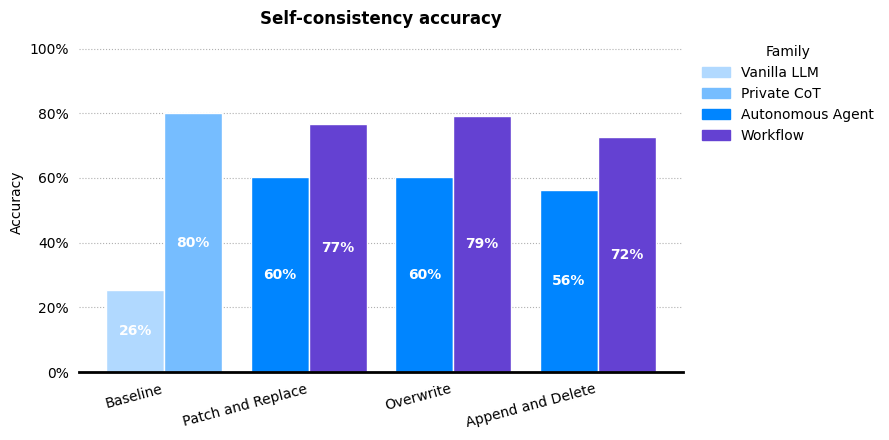

In [7]:
# === Figure: Overall self-consistency accuracy (revealed_yes) by agent family & strategy ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Visual palette (keep your colors) ---
PALETTE_LIST = [
    "#b1d9ff", "#76bdff", "#3ba1ff", "#0085ff",
    "#6441d2", "#004bba", "#48a5fb", "#cce6ff",
]

FAMILY_COLORS = {
    "Vanilla LLM": PALETTE_LIST[0],
    "Private CoT": PALETTE_LIST[1],
    "Autonomous Agent":       PALETTE_LIST[3],
    "Workflow":    PALETTE_LIST[4],
}

STRATEGY_ORDER = ["Patch and Replace", "Overwrite", "Append and Delete"]

# Map agent -> (family, strategy)
_AGENT_MAP = {
    # baselines
    "vanilla_llm_agent": ("Vanilla LLM", "Baseline"),
    "private_cot_agent": ("Private CoT", "Baseline"),
    # reactmem
    "reactmem_overwrite_agent":            ("Autonomous Agent", "Overwrite"),
    "reactmem_patch_and_replace_agent":    ("Autonomous Agent", "Patch and Replace"),
    "reactmem_append_and_delete_agent":    ("Autonomous Agent", "Append and Delete"),
    # workflow
    "workflow_overwrite_agent":            ("Workflow", "Overwrite"),
    "workflow_patch_and_replace_agent":    ("Workflow", "Patch and Replace"),
    "workflow_append_and_delete_agent":    ("Workflow", "Append and Delete"),
}

def _nice_axes_style(ax, grid_axis="y"):
    """Clean styling consistent with your template."""
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(left=False, bottom=False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    if grid_axis == "y":
        ax.spines["left"].set_visible(False)
        ax.spines["bottom"].set_linewidth(2)
        ax.yaxis.grid(True, which="major", linestyle=":")
    else:
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_linewidth(2)
        ax.xaxis.grid(True, which="major", linestyle=":")
    ax.set_axisbelow(True)

def _add_value_labels(ax, fmt="{:.2f}", min_abs_height=0.005, inside=True):
    """Center bold white labels in percentage bars."""
    for rect in ax.patches:
        h = rect.get_height()
        if abs(h) >= min_abs_height:
            x = rect.get_x() + rect.get_width() / 2.0
            y = rect.get_y() + h / 2.0 if inside else h
            ax.text(
                x, y if inside else h,
                # fmt.format(h), # not this but in integer percentage 
                f"{h:.0%}",
                fontsize=10, ha="center",
                va="center" if inside else "bottom",
                color="white", weight="bold",
            )

def plot_self_consistency_accuracy(evaluations):
    # --- Prep data from the new evaluations df ---
    df = evaluations.copy()

    # (Optional) If you want to keep only a specific game, uncomment:
    # df = df[df["game"] == "hangman_sct"].copy()

    # Keep only rows whose agent we can map
    df = df[df["agent"].isin(_AGENT_MAP.keys())].copy()

    # Map family/strategy
    df["family"] = df["agent"].map(lambda a: _AGENT_MAP[a][0])
    df["strategy"] = df["agent"].map(lambda a: _AGENT_MAP[a][1])

    # Aggregate: mean self-consistency accuracy (revealed_yes) per agent, then average within (family, strategy)
    g = (
        df.groupby(["model", "agent", "family", "strategy"], as_index=False)["revealed_yes"]
        .mean()
        .groupby(["family", "strategy"], as_index=False)["revealed_yes"]
        .mean()
    )

    # We will show one "Baseline" cluster for Vanilla/Private CoT, and 3 clusters for strategies.
    clusters = ["Baseline"] + STRATEGY_ORDER
    x_pos = {name: i for i, name in enumerate(clusters)}

    fig, ax = plt.subplots(figsize=(9, 4.5))

    # --- Draw Baseline cluster: Vanilla & Private CoT (if present) ---
    baseline_fams = ["Vanilla LLM", "Private CoT"]
    baseline_vals = []
    baseline_present = False

    for i, fam in enumerate(baseline_fams):
        val = g.loc[(g["family"] == fam) & (g["strategy"] == "Baseline"), "revealed_yes"]
        if not val.empty:
            baseline_present = True
            baseline_vals.append((fam, float(val.iloc[0])))

    if baseline_present:
        # If both present, split the cluster so bars touch; if one, center it.
        n = len(baseline_vals)
        cluster_width = 0.8
        bar_w = cluster_width / max(n, 1)
        offsets = np.arange(n) * bar_w - (cluster_width - bar_w) / 2.0
        for (off, (fam, v)) in zip(offsets, baseline_vals):
            ax.bar(
                x_pos["Baseline"] + off,
                v,
                width=bar_w,
                color=FAMILY_COLORS[fam],
                edgecolor="white",
                label=fam,
            )

    # --- Draw strategy clusters for ReAct & Workflow ---
    for s in STRATEGY_ORDER:
        fams_here = []
        vals_here = []
        for fam in ["Autonomous Agent", "Workflow"]:
            val = g.loc[(g["family"] == fam) & (g["strategy"] == s), "revealed_yes"]
            if not val.empty:
                fams_here.append(fam)
                vals_here.append(float(val.iloc[0]))
        if not fams_here:
            continue
        n = len(fams_here)
        cluster_width = 0.8
        bar_w = cluster_width / n
        offsets = np.arange(n) * bar_w - (cluster_width - bar_w) / 2.0
        for off, fam, v in zip(offsets, fams_here, vals_here):
            ax.bar(
                x_pos[s] + off,
                v,
                width=bar_w,
                color=FAMILY_COLORS[fam],
                edgecolor="white",
                label=fam,
            )

    # X ticks and labels
    ax.set_xticks([x_pos[name] for name in clusters])
    ax.set_xticklabels(clusters, rotation=15, ha="right")

    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], labels=["0%", "20%", "40%", "60%", "80%", "100%"])

    # Style & limits
    _nice_axes_style(ax, grid_axis="y")
    ax.set_ylim(0.0, 1.05)

    # Value labels in percentage
    _add_value_labels(ax, fmt="{:.2f}")

    # Title / y-label
    ax.set_title("Self-consistency accuracy", pad=6, fontweight="bold")
    ax.set_ylabel("Accuracy")

    # Build a deduplicated legend for families (keep your colors)
    handles = []
    labels = []
    for fam in ["Vanilla LLM", "Private CoT", "Autonomous Agent", "Workflow"]:
        if ((g["family"] == fam).any()):
            handles.append(plt.Rectangle((0,0),1,1,color=FAMILY_COLORS[fam]))
            labels.append(fam)
    leg = ax.legend(handles, labels, loc="upper left", bbox_to_anchor=(1.01, 1.0), frameon=False, title="Family")

    plt.tight_layout()
    plt.show()

df = evaluations[evaluations['model'] == 'qwen3_235b_openrouter']
plot_self_consistency_accuracy(evaluations)

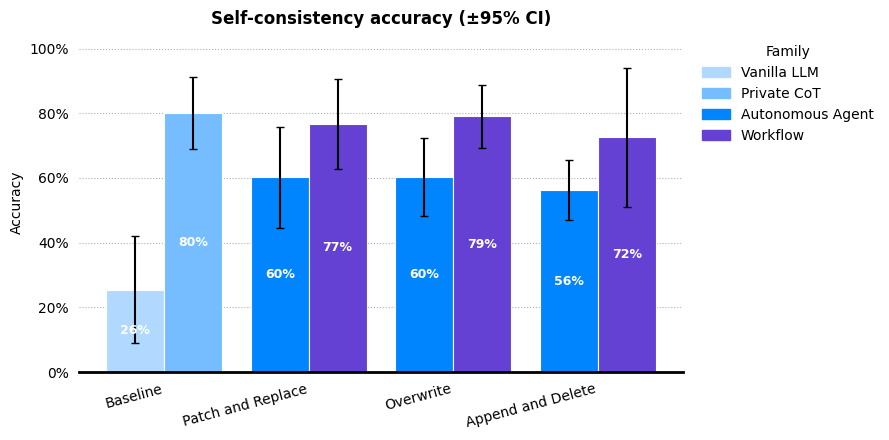

In [8]:
def plot_self_consistency_accuracy(evaluations):
    """
    Overall self-consistency accuracy (revealed_yes) by agent family & strategy,
    with 95% CIs computed over per-(model, agent) means.
    """
    df = evaluations.copy()
    df = df[df["agent"].isin(_AGENT_MAP.keys())].copy()

    # Map family/strategy
    df["family"]   = df["agent"].map(lambda a: _AGENT_MAP[a][0])
    df["strategy"] = df["agent"].map(lambda a: _AGENT_MAP[a][1])

    # 1) Mean per (model, agent) to avoid overweighting models with more rows
    per_ma = (df.groupby(["model", "agent", "family", "strategy"], as_index=False)["revealed_yes"]
                .mean()
                .rename(columns={"revealed_yes": "revealed_yes_ma"}))

    # 2) Aggregate those per-(model,agent) means per (family, strategy) with CI
    agg = (per_ma.groupby(["family", "strategy"], as_index=False)["revealed_yes_ma"]
                 .agg(mean="mean", std="std", N="size"))
    agg["sem"] = agg["std"] / np.sqrt(agg["N"].clip(lower=1))
    agg["ci"]  = 1.96 * agg["sem"].fillna(0.0)

    # Helper to fetch mean/ci for a (family, strategy) or return None
    def get_stats(fam, strat):
        row = agg[(agg["family"] == fam) & (agg["strategy"] == strat)]
        if row.empty:
            return None
        r = row.iloc[0]
        return float(r["mean"]), float(r["ci"])

    # Layout
    clusters = ["Baseline"] + STRATEGY_ORDER
    x_pos = {name: i for i, name in enumerate(clusters)}
    fig, ax = plt.subplots(figsize=(9, 4.5))

    # --- Baseline cluster: Vanilla & Private CoT ---
    baseline_fams = ["Vanilla LLM", "Private CoT"]
    present = [(fam, get_stats(fam, "Baseline")) for fam in baseline_fams]
    present = [(fam, stats) for fam, stats in present if stats is not None]

    if present:
        n = len(present)
        cluster_width = 0.8
        bar_w = cluster_width / n
        offsets = np.arange(n) * bar_w - (cluster_width - bar_w) / 2.0
        for off, (fam, (mean_v, ci_v)) in zip(offsets, present):
            ax.bar(
                x_pos["Baseline"] + off,
                mean_v,
                width=bar_w,
                color=FAMILY_COLORS[fam],
                edgecolor="white",
                yerr=ci_v,
                capsize=3,
                ecolor="black",
                linewidth=0.8,
            )

    # --- Strategy clusters for Autonomous & Workflow ---
    for strat in STRATEGY_ORDER:
        fams = []
        stats = []
        for fam in ["Autonomous Agent", "Workflow"]:
            s = get_stats(fam, strat)
            if s is not None:
                fams.append(fam)
                stats.append(s)
        if not fams:
            continue
        n = len(fams)
        cluster_width = 0.8
        bar_w = cluster_width / n
        offsets = np.arange(n) * bar_w - (cluster_width - bar_w) / 2.0
        for off, fam, (mean_v, ci_v) in zip(offsets, fams, stats):
            ax.bar(
                x_pos[strat] + off,
                mean_v,
                width=bar_w,
                color=FAMILY_COLORS[fam],
                edgecolor="white",
                yerr=ci_v,
                capsize=3,
                ecolor="black",
                linewidth=0.8,
            )

    # X/Y ticks and styling
    ax.set_xticks([x_pos[name] for name in clusters])
    ax.set_xticklabels(clusters, rotation=15, ha="right")
    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
                  labels=["0%", "20%", "40%", "60%", "80%", "100%"])
    _nice_axes_style(ax, grid_axis="y")
    ax.set_ylim(0.0, 1.05)

    # (Optional) value labels centered in bars
    for rect in ax.patches:
        h = rect.get_height()
        if h > 0:
            ax.text(rect.get_x() + rect.get_width()/2.0,
                    rect.get_y() + h/2.0,
                    f"{h:.0%}",
                    ha="center", va="center",
                    color="white", fontsize=9, fontweight="bold")

    # Titles/labels AFTER styling (since _nice_axes_style clears them in your template)
    ax.set_title("Self-consistency accuracy (±95% CI)", pad=6, fontweight="bold")
    ax.set_ylabel("Accuracy")

    # Legend (families)
    handles, labels = [], []
    for fam in ["Vanilla LLM", "Private CoT", "Autonomous Agent", "Workflow"]:
        if ((agg["family"] == fam).any()):
            handles.append(plt.Rectangle((0,0),1,1,color=FAMILY_COLORS[fam]))
            labels.append(fam)
    ax.legend(handles, labels, loc="upper left", bbox_to_anchor=(1.01, 1.0),
              frameon=False, title="Family")

    plt.tight_layout()
    plt.show()

plot_self_consistency_accuracy(evaluations)

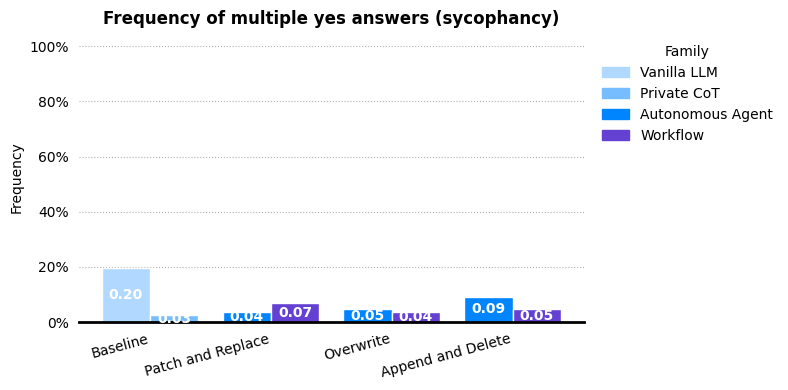

In [9]:
# === Figure: Selectivity vs. sycophancy by agent family & strategy ===
# Plots 1 - more_than_one_yes (higher = better) by default; can switch to raw sycophancy rate.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Visual palette (keep your colors) ---
PALETTE_LIST = [
    "#b1d9ff", "#76bdff", "#3ba1ff", "#0085ff",
    "#6441d2", "#004bba", "#48a5fb", "#cce6ff",
]

FAMILY_COLORS = {
    "Vanilla LLM": PALETTE_LIST[0],
    "Private CoT": PALETTE_LIST[1],
    "Autonomous Agent": PALETTE_LIST[3],
    "Workflow": PALETTE_LIST[4],
}

STRATEGY_ORDER = ["Patch and Replace", "Overwrite", "Append and Delete"]

# Map agent -> (family, strategy)
_AGENT_MAP = {
    # baselines
    "vanilla_llm_agent": ("Vanilla LLM", "Baseline"),
    "private_cot_agent": ("Private CoT", "Baseline"),
    # autonomous
    "reactmem_overwrite_agent":         ("Autonomous Agent", "Overwrite"),
    "reactmem_patch_and_replace_agent": ("Autonomous Agent", "Patch and Replace"),
    "reactmem_append_and_delete_agent": ("Autonomous Agent", "Append and Delete"),
    # workflows
    "workflow_overwrite_agent":         ("Workflow", "Overwrite"),
    "workflow_patch_and_replace_agent": ("Workflow", "Patch and Replace"),
    "workflow_append_and_delete_agent": ("Workflow", "Append and Delete"),
}

def _nice_axes_style(ax, grid_axis="y"):
    """Clean styling consistent with your template."""
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(left=False, bottom=False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    if grid_axis == "y":
        ax.spines["left"].set_visible(False)
        ax.spines["bottom"].set_linewidth(2)
        ax.yaxis.grid(True, which="major", linestyle=":")
    else:
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_linewidth(2)
        ax.xaxis.grid(True, which="major", linestyle=":")
    ax.set_axisbelow(True)

def _add_value_labels(ax, fmt="{:.2f}", min_abs_height=0.005, inside=True):
    """Center bold white labels on bars."""
    for rect in ax.patches:
        h = rect.get_height()
        if abs(h) >= min_abs_height:
            x = rect.get_x() + rect.get_width() / 2.0
            y = rect.get_y() + h / 2.0 if inside else h
            ax.text(
                x, y if inside else h,
                fmt.format(h),
                fontsize=10, ha="center",
                va="center" if inside else "bottom",
                color="white", weight="bold",
            )

def plot_sycophancy(evaluations: pd.DataFrame, invert: bool = True):
    """
    Plot sycophancy/selectivity by agent family & strategy.

    Parameters
    ----------
    evaluations : DataFrame with columns including:
        ['model','agent','game','more_than_one_yes', ...]
        more_than_one_yes is a per-trial indicator (1 if >1 'yes' among candidates; else 0)
    invert : bool
        If True, plot selectivity = 1 - mean(more_than_one_yes)  (higher = better).
        If False, plot sycophancy rate = mean(more_than_one_yes) (lower = better).
    """
    df = evaluations.copy()
    df = df[df["agent"].isin(_AGENT_MAP.keys())].copy()

    # Map family/strategy
    df["family"] = df["agent"].map(lambda a: _AGENT_MAP[a][0])
    df["strategy"] = df["agent"].map(lambda a: _AGENT_MAP[a][1])

    # Aggregate per (model, agent) first, then average within (family, strategy)
    metric = "more_than_one_yes"
    g = (
        df.groupby(["model", "agent", "family", "strategy"], as_index=False)[metric]
          .mean()
          .groupby(["family", "strategy"], as_index=False)[metric]
          .mean()
    )

    # Apply inversion if requested
    if invert:
        g["value"] = 1.0 - g[metric]
        title = "Selectivity (1 − fraction of trials with >1 'yes')"
        ylabel = "Selectivity (higher is better)"
    else:
        g["value"] = g[metric]
        title = "Frequency of multiple yes answers (sycophancy)"
        ylabel = "Frequency"

    # Build clusters: Baseline + strategies
    clusters = ["Baseline"] + STRATEGY_ORDER
    x_pos = {name: i for i, name in enumerate(clusters)}

    fig, ax = plt.subplots(figsize=(8, 4))

    # --- Baseline cluster (Vanilla, Private CoT) ---
    baseline_fams = ["Vanilla LLM", "Private CoT"]
    base_vals = []
    for fam in baseline_fams:
        v = g.loc[(g["family"] == fam) & (g["strategy"] == "Baseline"), "value"]
        if not v.empty:
            base_vals.append((fam, float(v.iloc[0])))

    if base_vals:
        n = len(base_vals)
        cluster_width = 0.8
        bar_w = cluster_width / n
        offsets = np.arange(n) * bar_w - (cluster_width - bar_w) / 2.0
        for (off, (fam, v)) in zip(offsets, base_vals):
            ax.bar(
                x_pos["Baseline"] + off,
                v,
                width=bar_w,
                color=FAMILY_COLORS[fam],
                edgecolor="white",
                label=fam,
            )

    # --- Strategy clusters (Autonomous Agent, Workflow) ---
    for s in STRATEGY_ORDER:
        fams_here, vals_here = [], []
        for fam in ["Autonomous Agent", "Workflow"]:
            v = g.loc[(g["family"] == fam) & (g["strategy"] == s), "value"]
            if not v.empty:
                fams_here.append(fam)
                vals_here.append(float(v.iloc[0]))
        if not fams_here:
            continue
        n = len(fams_here)
        cluster_width = 0.8
        bar_w = cluster_width / n
        offsets = np.arange(n) * bar_w - (cluster_width - bar_w) / 2.0
        for off, fam, v in zip(offsets, fams_here, vals_here):
            ax.bar(
                x_pos[s] + off,
                v,
                width=bar_w,
                color=FAMILY_COLORS[fam],
                edgecolor="white",
                label=fam,
            )

    # Ticks, style, labels
    ax.set_xticks([x_pos[name] for name in clusters])
    ax.set_xticklabels(clusters, rotation=15, ha="right")
    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], labels=["0%", "20%", "40%", "60%", "80%", "100%"])
    _nice_axes_style(ax, grid_axis="y")
    ax.set_ylim(0.0, 1.05)
    _add_value_labels(ax, fmt="{:.2f}")

    ax.set_title(title, pad=6, fontweight="bold")
    ax.set_ylabel(ylabel)

    # Legend on the side (families)
    handles, labels = [], []
    for fam in ["Vanilla LLM", "Private CoT", "Autonomous Agent", "Workflow"]:
        if (g["family"] == fam).any():
            handles.append(plt.Rectangle((0,0),1,1,color=FAMILY_COLORS[fam]))
            labels.append(fam)
    ax.legend(handles, labels, loc="upper left", bbox_to_anchor=(1.01, 1.0),
              frameon=False, title="Family")

    plt.tight_layout()
    plt.show()

# Example calls:
df = evaluations[evaluations['model'] == 'qwen3_235b_openrouter']
plot_sycophancy(evaluations, invert=False)   # Selectivity (higher=better)
# plot_sycophancy(evaluations, invert=False)  # Sycophancy rate (lower=better)

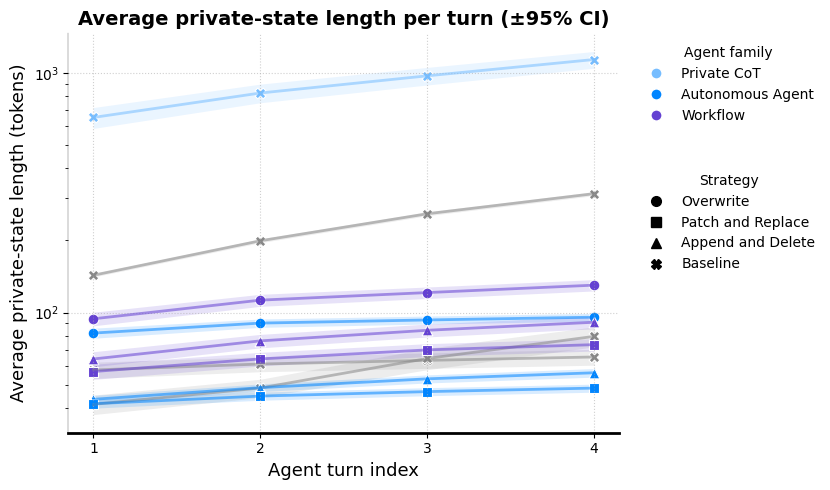

In [10]:
# === Cell: Average private-state length per turn per agent (styled like forests) — side legends ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

# --- Visual palette (keep your colors) ---
PALETTE_LIST = [
    "#b1d9ff", "#76bdff", "#3ba1ff", "#0085ff",
    "#6441d2", "#004bba", "#48a5fb", "#cce6ff",
]

FAMILY_COLORS = {
    "Vanilla LLM": PALETTE_LIST[0],
    "Private CoT": PALETTE_LIST[1],
    "Autonomous Agent": PALETTE_LIST[3],
    "Workflow": PALETTE_LIST[4],
}

# Map agent -> (family, strategy) — include BOTH with and without `_agent`
_AGENT_MAP = {
    # baselines
    "vanilla_llm": ("Vanilla LLM", "Baseline"),
    "vanilla_llm_agent": ("Vanilla LLM", "Baseline"),
    "private_cot": ("Private CoT", "Baseline"),
    "private_cot_agent": ("Private CoT", "Baseline"),
    # autonomous (reactmem)
    "reactmem_overwrite": ("Autonomous Agent", "Overwrite"),
    "reactmem_overwrite_agent": ("Autonomous Agent", "Overwrite"),
    "reactmem_patch_and_replace": ("Autonomous Agent", "Patch and Replace"),
    "reactmem_patch_and_replace_agent": ("Autonomous Agent", "Patch and Replace"),
    "reactmem_append_and_delete": ("Autonomous Agent", "Append and Delete"),
    "reactmem_append_and_delete_agent": ("Autonomous Agent", "Append and Delete"),
    # workflows
    "workflow_overwrite": ("Workflow", "Overwrite"),
    "workflow_overwrite_agent": ("Workflow", "Overwrite"),
    "workflow_patch_and_replace": ("Workflow", "Patch and Replace"),
    "workflow_patch_and_replace_agent": ("Workflow", "Patch and Replace"),
    "workflow_append_and_delete": ("Workflow", "Append and Delete"),
    "workflow_append_and_delete_agent": ("Workflow", "Append and Delete"),
}

def _norm_agent_key(a: str) -> str:
    """Normalize agent id: lowercase, strip spaces, drop optional `_agent` suffix."""
    if not isinstance(a, str):
        return str(a)
    s = a.strip().lower()
    s = re.sub(r"\s+", "_", s)
    s = re.sub(r"_agent$", "", s)  # tolerate both with/without suffix
    if s in _AGENT_MAP:
        return s
    if f"{s}_agent" in _AGENT_MAP:
        return f"{s}_agent"
    return s

def _agent_family(agent: str) -> str:
    key = _norm_agent_key(agent)
    return _AGENT_MAP.get(key, (agent, ""))[0]

def _agent_strategy(agent: str) -> str:
    key = _norm_agent_key(agent)
    return _AGENT_MAP.get(key, ("", "Baseline"))[1]

def build_private_len_long(interaction_logs: pd.DataFrame, drop_zero=True, max_turns=None):
    """
    Return long-form DF with one row per (episode, agent turn).
    Columns: model, game, agent, family, strategy, episode_id, turn_idx (1..), length
    Uses interaction_logs['private_state_lengths'] built earlier.
    """
    df = interaction_logs.copy()
    if "private_state_lengths" not in df.columns:
        raise ValueError("Expected 'private_state_lengths' on interaction_logs. Run the extraction cell first.")

    df["episode_id"] = df.get("filepath", df.index)
    df["turn_idx_list"] = df["private_state_lengths"].apply(
        lambda L: list(range(1, len(L)+1)) if isinstance(L, (list, tuple)) else []
    )

    df_long = df.explode(["private_state_lengths", "turn_idx_list"], ignore_index=True)
    df_long = df_long.rename(columns={"private_state_lengths": "length", "turn_idx_list": "turn_idx"})

    df_long["length"] = pd.to_numeric(df_long["length"], errors="coerce").fillna(0).astype(int)
    df_long["turn_idx"] = pd.to_numeric(df_long["turn_idx"], errors="coerce").astype("Int64")

    if drop_zero:
        df_long = df_long[df_long["length"] > 0]

    if max_turns is not None:
        df_long = df_long[df_long["turn_idx"].notna() & (df_long["turn_idx"] <= max_turns)]

    # Enrich with normalized mapping
    df_long["family"] = df_long["agent"].map(_agent_family)
    df_long["strategy"] = df_long["agent"].map(_agent_strategy)

    df_long = df_long[df_long["turn_idx"].notna()].copy()
    df_long["turn_idx"] = df_long["turn_idx"].astype(int)
    return df_long

def aggregate_per_turn_agent(interaction_logs, drop_zero=True, max_turns=None):
    """Aggregate mean ±95% CI of private-state length per agent & turn."""
    df_long = build_private_len_long(interaction_logs, drop_zero=drop_zero, max_turns=max_turns)
    grp = (df_long
           .groupby(["agent","family","strategy","turn_idx"])
           .agg(mean_len=("length","mean"),
                std_len=("length","std"),
                N=("length","size"))
           .reset_index())
    grp["sem"] = grp["std_len"] / np.sqrt(grp["N"].clip(lower=1))
    grp["ci"]  = 1.96 * grp["sem"].fillna(0)
    grp["lo"]  = (grp["mean_len"] - grp["ci"]).clip(lower=0)
    grp["hi"]  = grp["mean_len"] + grp["ci"]
    return grp

def plot_avg_len_per_turn(interaction_logs, drop_zero=True, max_turns=None, annotate_last=True, min_sep=15):
    """
    Plot average private-state length per turn per agent with CI ribbons.
    Styled to match your forest-like aesthetics. Legends placed on the side.
    """
    df = aggregate_per_turn_agent(interaction_logs, drop_zero=drop_zero, max_turns=max_turns)
    if df.empty:
        print("No private-state lengths to plot."); 
        return

    fig, ax = plt.subplots(figsize=(8, 5))
    marker_map = {"Baseline":"X","Overwrite":"o","Patch and Replace":"s","Append and Delete":"^"}

    last_points = []

    # Draw lines + ribbons
    for agent, d in df.groupby("agent"):
        fam = d["family"].iloc[0]
        strat = d["strategy"].iloc[0]
        color = FAMILY_COLORS.get(fam, "#888888")
        marker = marker_map.get(strat, "o")

        d = d.sort_values("turn_idx")
        ax.fill_between(d["turn_idx"], d["lo"], d["hi"], alpha=0.15, color=color, linewidth=0)
        ax.plot(d["turn_idx"], d["mean_len"], "-", color=color, linewidth=2, alpha=0.55,
                label=f"{fam} — {strat}")
        ax.scatter(d["turn_idx"], d["mean_len"], s=60, color=color, marker=marker,
                   edgecolor="white", linewidth=0.8)

        if annotate_last and not d.empty:
            last_row = d.iloc[-1]
            last_points.append((last_row["mean_len"], f"{last_row['mean_len']:.0f}", color, last_row["turn_idx"]))

    # De-overlap last-point labels
    if annotate_last and last_points:
        last_points.sort(key=lambda x: x[0])
        adjusted_y = []
        for y, label, color, turn_idx in last_points:
            if not adjusted_y:
                adjusted_y.append(y)
            else:
                prev_y = adjusted_y[-1]
                if y - prev_y < min_sep:
                    y = prev_y + min_sep
                adjusted_y.append(y)
            ax.text(turn_idx + 0.3, y, label, color=color, fontsize=9, va="center")

    # Axes style
    ax.set_xlabel("Agent turn index", fontsize=13)
    ax.set_ylabel("Average private-state length (tokens)", fontsize=13)
    ax.set_title("Average private-state length per turn (±95% CI)", fontweight="bold", fontsize=14)
    ax.grid(True, linestyle=":", alpha=0.6)
    ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_linewidth(2); ax.spines["left"].set_linewidth(0.2)
    ax.set_yscale("log")

    max_turn = int(df["turn_idx"].max())
    ax.set_xticks(range(1, max_turn+1))

    # Build separate legends: families (colors) and strategies (markers), placed on the right
    fam_labels = [f for f in FAMILY_COLORS.keys() if f != "Vanilla LLM"]  # omit Vanilla LLM if desired
    fam_handles = [
        plt.Line2D([0],[0], marker='o', color='none', markerfacecolor=FAMILY_COLORS[f],
                   markeredgecolor="white", markersize=8, label=f)
        for f in fam_labels
    ]
    strat_map = {"Overwrite":"o","Patch and Replace":"s","Append and Delete":"^","Baseline":"X"}
    strat_labels = ["Overwrite", "Patch and Replace", "Append and Delete", "Baseline"]
    strat_handles = [
        plt.Line2D([0],[0], marker=mk, color='black', linestyle='none',
                   markerfacecolor="black", markersize=7, label=lab)
        for lab, mk in strat_map.items()
    ]

    # Place legends outside the axes on the right (stacked)
    leg1 = ax.legend(fam_handles, fam_labels, title="Agent family",
                     loc="upper left", bbox_to_anchor=(1.02, 1.0), frameon=False)
    ax.add_artist(leg1)
    ax.legend(strat_handles, strat_labels, title="Strategy",
              loc="upper left", bbox_to_anchor=(1.02, 0.68), frameon=False)

    # Make room for side legends
    plt.tight_layout(rect=[0, 0, 0.68, 1])
    
    plt.subplots_adjust(right=0.78)
    plt.show()

# Example
plot_avg_len_per_turn(interaction_logs, drop_zero=True, max_turns=12, annotate_last=False)

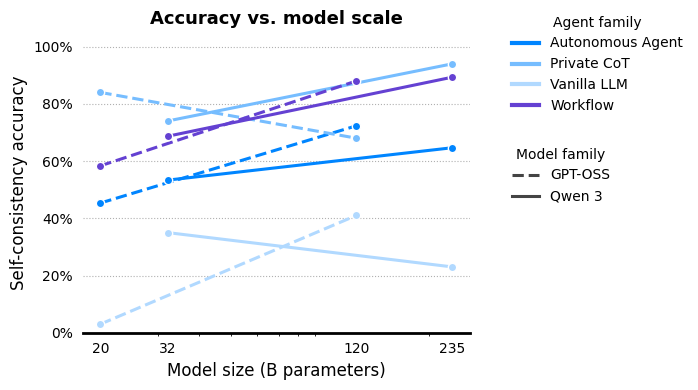

In [11]:
# === Figure: Accuracy vs. model scale (revealed_yes) — single plot
# One line per AGENT FAMILY; line style encodes MODEL FAMILY; colors encode AGENT FAMILY.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# --- Visual palette (keep your colors) ---
PALETTE_LIST = [
    "#b1d9ff", "#76bdff", "#3ba1ff", "#0085ff",
    "#6441d2", "#004bba", "#48a5fb", "#cce6ff",
]

FAMILY_COLORS = {
    "Vanilla LLM": PALETTE_LIST[0],
    "Private CoT": PALETTE_LIST[1],
    "Autonomous Agent": PALETTE_LIST[3],
    "Workflow": PALETTE_LIST[4],
}

# Agent -> (family, strategy)
_AGENT_MAP = {
    # baselines
    "vanilla_llm_agent": ("Vanilla LLM", "Baseline"),
    "private_cot_agent": ("Private CoT", "Baseline"),
    # autonomous (reactmem)
    "reactmem_overwrite_agent": ("Autonomous Agent", "Overwrite"),
    "reactmem_patch_and_replace_agent": ("Autonomous Agent", "Patch and Replace"),
    "reactmem_append_and_delete_agent": ("Autonomous Agent", "Append and Delete"),
    # workflows
    "workflow_overwrite_agent": ("Workflow", "Overwrite"),
    "workflow_patch_and_replace_agent": ("Workflow", "Patch and Replace"),
    "workflow_append_and_delete_agent": ("Workflow", "Append and Delete"),
}

# Model -> size in billions
_MODEL_SIZE = {
    "gpt_oss_20b_openrouter": 20,
    "gpt_oss_120b_openrouter": 120,
    "qwen3_32b_openrouter": 32,
    "qwen3_235b_openrouter": 235,
}

# Model family -> line style
_MODEL_FAMILY_LS = {
    "Qwen 3": "-",
    "GPT-OSS": "--",
}

def _model_family(model: str) -> str:
    m = str(model).lower()
    if "qwen3" in m:
        return "Qwen 3"
    if "gpt_oss" in m:
        return "GPT-OSS"
    return "Other"

def _nice_axes_style(ax, grid_axis="y"):
    # ax.set_xlabel("")
    # ax.set_ylabel("")
    ax.tick_params(left=False, bottom=False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    if grid_axis == "y":
        ax.spines["left"].set_visible(False)
        ax.spines["bottom"].set_linewidth(2)
        ax.yaxis.grid(True, which="major", linestyle=":")
    else:
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_linewidth(2)
        ax.xaxis.grid(True, which="major", linestyle=":")
    ax.set_axisbelow(True)

def plot_scale_aggregate(
    evaluations: pd.DataFrame,
    xlog: bool = True,
    xticks: list | None = None,
    include_families: list | None = None,
):
    """
    Single-axes plot of revealed_yes accuracy vs model size.
    - One line per AGENT FAMILY (Vanilla LLM, Private CoT, Autonomous Agent, Workflow).
    - Line STYLE encodes MODEL FAMILY (Qwen 3 solid, GPT-OSS dashed).
    - Color encodes agent family.
    """

    df = evaluations.copy()

    # Ensure model_size column exists
    if "model_size" not in df.columns:
        df["model_size"] = df["model"].map(_MODEL_SIZE)

    # Filter to mapped agents and non-null sizes
    df = df[df["agent"].isin(_AGENT_MAP.keys())].copy()
    df = df[df["model_size"].notna()].copy()

    # Map agent family & model family
    df["family"] = df["agent"].map(lambda a: _AGENT_MAP[a][0])
    df["model_family"] = df["model"].map(_model_family)

    # Optional filter of agent families
    if include_families is not None:
        df = df[df["family"].isin(include_families)].copy()

    # Aggregate: mean accuracy per (model_family, model_size, family)
    agg = (df.groupby(["model_family","model_size","family"], as_index=False)["revealed_yes"]
             .mean())
    agg = agg[agg["family"].isin(FAMILY_COLORS.keys())]

    # --- Figure ---
    fig, ax = plt.subplots(figsize=(7, 4))

    # Determine sizes / ticks
    sizes_all = sorted(agg["model_size"].unique().tolist())
    if xticks is None:
        xticks = sizes_all

    # Plot lines
    handles_fam, handles_mf = {}, {}
    for (fam, mf), d in agg.groupby(["family","model_family"]):
        d = d.sort_values("model_size")
        color = FAMILY_COLORS.get(fam, "#888888")
        ls = _MODEL_FAMILY_LS.get(mf, "-.")

        ax.plot(
            d["model_size"], d["revealed_yes"],
            linestyle=ls, linewidth=2.2,
            marker="o", markersize=6,
            color=color, markeredgecolor="white",
        )

        if fam not in handles_fam:
            fam_line, = ax.plot([], [], color=color, linewidth=3, label=fam)
            handles_fam[fam] = fam_line
        if mf not in handles_mf:
            mf_line, = ax.plot([], [], color="#444444", linestyle=ls, linewidth=2.2, label=mf)
            handles_mf[mf] = mf_line

    # Axes cosmetics
    if xlog:
        ax.set_xscale("log", base=10)
        ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.set_xticks(xticks)
    ax.set_yticks(
        [0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
        labels=["0%", "20%", "40%", "60%", "80%", "100%"]
    )
    ax.set_xlabel("Model size (B parameters)", fontsize=12)
    ax.set_ylabel("Self-consistency accuracy", fontsize=12)
    ax.set_title("Accuracy vs. model scale", pad=6, fontsize=13, fontweight="bold")
    _nice_axes_style(ax, grid_axis="y")
    ax.set_ylim(0.0, 1.05)

    # --- Legends in the right gutter (figure coordinates) ---
    fam_labels, fam_handles = list(handles_fam.keys()), list(handles_fam.values())
    mf_labels, mf_handles   = list(handles_mf.keys()), list(handles_mf.values())

    # Reserve 70% width for axes; 30% for legends
    plt.tight_layout(rect=[0, 0, 0.70, 1])

    leg1 = ax.legend(fam_handles, fam_labels, title="Agent family",
                     loc="upper left", bbox_to_anchor=(0.72, 0.98),
                     bbox_transform=fig.transFigure, frameon=False)
    ax.add_artist(leg1)

    ax.legend(mf_handles, mf_labels, title="Model family",
              loc="upper left", bbox_to_anchor=(0.72, 0.65),
              bbox_transform=fig.transFigure, frameon=False)

    plt.show()

plot_scale_aggregate(evaluations)

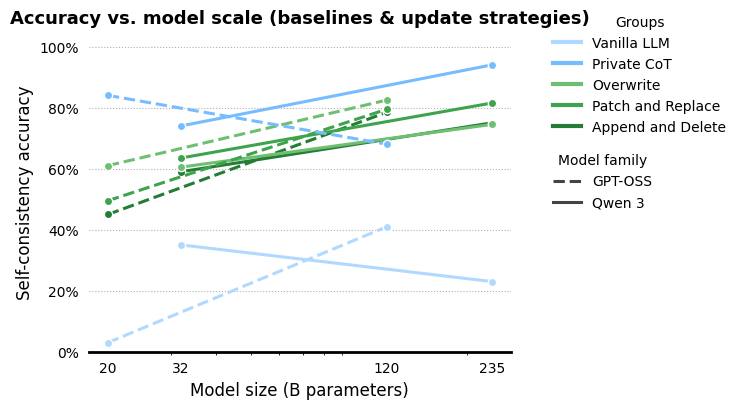

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import re

# --- Visual palette (keep your blues) ---
PALETTE_LIST = [
    "#b1d9ff", "#76bdff", "#3ba1ff", "#0085ff",
    "#6441d2", "#004bba", "#48a5fb", "#cce6ff",
]

BASELINE_COLORS = {
    "Vanilla LLM": PALETTE_LIST[0],
    "Private CoT": PALETTE_LIST[1],
}

# Three greens for update strategies
STRATEGY_COLORS = {
    "Overwrite":          "#6fbf73",  # light/medium green
    "Patch and Replace":  "#3ea34d",  # medium green
    "Append and Delete":  "#257c35",  # darker green
}

# Agent -> (family, strategy)
_AGENT_MAP = {
    # baselines
    "vanilla_llm_agent": ("Vanilla LLM", "Baseline"),
    "private_cot_agent": ("Private CoT", "Baseline"),
    # autonomous (reactmem)
    "reactmem_overwrite_agent": ("Autonomous Agent", "Overwrite"),
    "reactmem_patch_and_replace_agent": ("Autonomous Agent", "Patch and Replace"),
    "reactmem_append_and_delete_agent": ("Autonomous Agent", "Append and Delete"),
    # workflows
    "workflow_overwrite_agent": ("Workflow", "Overwrite"),
    "workflow_patch_and_replace_agent": ("Workflow", "Patch and Replace"),
    "workflow_append_and_delete_agent": ("Workflow", "Append and Delete"),
}

# Model -> size in billions
_MODEL_SIZE = {
    "gpt_oss_20b_openrouter": 20,
    "gpt_oss_120b_openrouter": 120,
    "qwen3_32b_openrouter": 32,
    "qwen3_235b_openrouter": 235,
}

# Model family -> line style
_MODEL_FAMILY_LS = {
    "Qwen 3": "-",
    "GPT-OSS": "--",
}

def _model_family(model: str) -> str:
    m = str(model).lower()
    if "qwen3" in m:     return "Qwen 3"
    if "gpt_oss" in m:   return "GPT-OSS"
    return "Other"

def _nice_axes_style(ax, grid_axis="y"):
    ax.tick_params(left=False, bottom=False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    if grid_axis == "y":
        ax.spines["left"].set_visible(False)
        ax.spines["bottom"].set_linewidth(2)
        ax.yaxis.grid(True, which="major", linestyle=":")
    else:
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_linewidth(2)
        ax.xaxis.grid(True, which="major", linestyle=":")
    ax.set_axisbelow(True)

def plot_scale_by_strategy(
    evaluations: pd.DataFrame,
    xlog: bool = True,
    xticks: list | None = None,
):
    """
    Accuracy vs model scale.
    - Baselines: 2 lines (Vanilla LLM, Private CoT) keep original blue colors.
    - Update strategies: 3 lines (Overwrite, Patch and Replace, Append and Delete), each averaged
      across Autonomous + Workflow, colored with greens.
    - Line STYLE encodes MODEL FAMILY (Qwen 3 solid, GPT-OSS dashed).
    """

    df = evaluations.copy()

    # model_size
    if "model_size" not in df.columns:
        df["model_size"] = df["model"].map(_MODEL_SIZE)

    # keep mapped agents + non-null sizes
    df = df[df["agent"].isin(_AGENT_MAP.keys())].copy()
    df = df[df["model_size"].notna()].copy()

    # map family, strategy, model_family
    df["family"] = df["agent"].map(lambda a: _AGENT_MAP[a][0])
    df["strategy"] = df["agent"].map(lambda a: _AGENT_MAP[a][1])
    df["model_family"] = df["model"].map(_model_family)

    # Build a unified "group" label:
    # - Baselines use their family name as the group
    # - Non-baselines use their strategy name (averaging Autonomous + Workflow together)
    df["group"] = np.where(df["strategy"] == "Baseline", df["family"], df["strategy"])

    # Aggregate mean accuracy by (model_family, model_size, group)
    agg = (df.groupby(["model_family", "model_size", "group"], as_index=False)["revealed_yes"]
             .mean())

    # Setup figure
    fig, ax = plt.subplots(figsize=(7.5, 4.2))

    # X ticks
    sizes_all = sorted(agg["model_size"].unique().tolist())
    if xticks is None:
        xticks = sizes_all

    # Color lookup for groups
    def _group_color(g: str) -> str:
        if g in BASELINE_COLORS:
            return BASELINE_COLORS[g]
        return STRATEGY_COLORS.get(g, "#888888")

    # Track legend handles
    handles_groups, handles_mf = {}, {}

    # Plot one line per (group, model_family)
    for (grp, mf), d in agg.groupby(["group", "model_family"]):
        d = d.sort_values("model_size")
        color = _group_color(grp)
        ls = _MODEL_FAMILY_LS.get(mf, "-.")
        ax.plot(
            d["model_size"], d["revealed_yes"],
            linestyle=ls, linewidth=2.2,
            marker="o", markersize=6,
            color=color, markeredgecolor="white",
        )
        if grp not in handles_groups:
            h, = ax.plot([], [], color=color, linewidth=3, label=grp)
            handles_groups[grp] = h
        if mf not in handles_mf:
            hmf, = ax.plot([], [], color="#444444", linestyle=ls, linewidth=2.2, label=mf)
            handles_mf[mf] = hmf

    # Axes cosmetics
    if xlog:
        ax.set_xscale("log", base=10)
        ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.set_xticks(xticks)
    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
                  labels=["0%", "20%", "40%", "60%", "80%", "100%"])
    ax.set_xlabel("Model size (B parameters)", fontsize=12)
    ax.set_ylabel("Self-consistency accuracy", fontsize=12)
    ax.set_title("Accuracy vs. model scale (baselines & update strategies)", pad=6,
                 fontsize=13, fontweight="bold")
    _nice_axes_style(ax, grid_axis="y")
    ax.set_ylim(0.0, 1.05)

    # Build two legends: groups (colors) and model families (line styles)
    # Order groups: baselines first, then strategies
    group_order = ["Vanilla LLM", "Private CoT", "Overwrite", "Patch and Replace", "Append and Delete"]
    group_labels = [g for g in group_order if g in handles_groups]
    group_handles = [handles_groups[g] for g in group_labels]

    mf_labels = list(handles_mf.keys())
    mf_handles = [handles_mf[m] for m in mf_labels]

    # Reserve right gutter for legends
    plt.tight_layout(rect=[0, 0, 0.70, 1])

    leg1 = ax.legend(group_handles, group_labels, title="Groups",
                     loc="upper left", bbox_to_anchor=(0.72, 0.98),
                     bbox_transform=fig.transFigure, frameon=False)
    ax.add_artist(leg1)

    ax.legend(mf_handles, mf_labels, title="Model family",
              loc="upper left", bbox_to_anchor=(0.72, 0.65),
              bbox_transform=fig.transFigure, frameon=False)

    plt.show()

# Usage:
plot_scale_by_strategy(evaluations)

In [13]:
def plot_accuracy_sycophancy_correlation(evaluations: pd.DataFrame, n_boot: int = 5000, seed: int = 0):
    """
    For each agent family:
      1) Aggregate per (agent, model) the mean revealed_yes and mean more_than_one_yes.
      2) Compute Pearson r across those (agent, model) points.
      3) Bootstrap 95% CI by resampling the (agent, model) points within the family.

    Bars: Pearson r with 95% CI. Hatched 'undef' bar indicates r is undefined (constant series).
    """
    df = evaluations.copy()

    needed = {"model","agent","revealed_yes","more_than_one_yes"}
    missing = needed - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    df = df[df["agent"].isin(_AGENT_MAP.keys())].copy()
    if df.empty:
        print("No rows with recognized agents to plot.")
        return

    # Map family
    df["family"] = df["agent"].map(lambda a: _AGENT_MAP[a][0])

    # Aggregate to one point per (agent, model)
    pts = (df.groupby(["family","agent","model"], as_index=False)
             .agg(revealed_yes=("revealed_yes","mean"),
                  more_than_one_yes=("more_than_one_yes","mean")))

    rng = np.random.default_rng(seed)
    rows = []
    for fam, d in pts.groupby("family"):
        x = d["revealed_yes"].to_numpy()
        y = d["more_than_one_yes"].to_numpy()

        # Pearson r (undefined if <2 points or zero variance)
        if len(x) < 2 or np.std(x) == 0 or np.std(y) == 0:
            r, lo, hi, is_nan = np.nan, np.nan, np.nan, True
        else:
            r, _ = pearsonr(x, y)
            # Bootstrap CI
            n = len(d)
            boot = []
            if n >= 3:
                for _ in range(n_boot):
                    idx = rng.integers(0, n, size=n)
                    xb, yb = x[idx], y[idx]
                    if np.std(xb) > 0 and np.std(yb) > 0:
                        rb, _ = pearsonr(xb, yb)
                        boot.append(rb)
            if boot:
                lo, hi = np.percentile(boot, [2.5, 97.5])
            else:
                lo, hi = np.nan, np.nan
            is_nan = False

        rows.append({"family": fam, "r": r, "lo": lo, "hi": hi, "is_nan": is_nan, "n_points": len(d)})

    corr_df = pd.DataFrame(rows)
    fam_order = ["Vanilla LLM", "Private CoT", "Autonomous Agent", "Workflow"]
    corr_df = corr_df.set_index("family").reindex(fam_order).reset_index()

    # Values to plot: put undefined bars at 0 with hatch, no CI
    corr_df["r_plot"]  = corr_df["r"].fillna(0.0)
    corr_df["lo_plot"] = np.where(corr_df["is_nan"], corr_df["r_plot"], corr_df["lo"])
    corr_df["hi_plot"] = np.where(corr_df["is_nan"], corr_df["r_plot"], corr_df["hi"])

    fig, ax = plt.subplots(figsize=(7, 4))
    x = np.arange(len(corr_df))

    # Bars
    for i, row in corr_df.iterrows():
        fam   = row["family"]
        color = FAMILY_COLORS.get(fam, "#888888")
        bar = ax.bar(
            x[i], row["r_plot"],
            color=color, edgecolor="white", width=0.65,
            hatch="///" if row["is_nan"] else None,
            alpha=0.55 if row["is_nan"] else 1.0,
        )
        # Top label
        label_txt = "undef" if row["is_nan"] else f"{row['r_plot']:.2f}"
        ax.text(x[i], row["r_plot"] + (0.04 if row["r_plot"] >= 0 else -0.06),
                label_txt, ha="center", va="bottom" if row["r_plot"]>=0 else "top",
                fontsize=9, color="#333333")

    # Error bars (skip for undefined)
    vals = corr_df["r_plot"].to_numpy()
    yerr = np.vstack([
        np.where(corr_df["is_nan"], 0.0, vals - corr_df["lo_plot"].to_numpy()),
        np.where(corr_df["is_nan"], 0.0, corr_df["hi_plot"].to_numpy() - vals),
    ])
    ax.errorbar(x, vals, yerr=yerr, fmt="none", ecolor="#333333",
                elinewidth=1.5, capsize=3, capthick=1.5)

    # Zero line and cosmetics
    ax.axhline(0, color="#555555", linewidth=1.2, linestyle="--", alpha=0.7)
    ax.set_xticks(x)
    ax.set_xticklabels(corr_df["family"], rotation=15, ha="right")
    ax.set_ylabel("Pearson correlation (r)")
    ax.set_title("Correlation between accuracy and sycophancy", fontweight="bold", pad=12)
    _nice_axes_style(ax, grid_axis="y")
    ax.set_ylim(-1.05, 1.05)

    # n points annotation
    for i, n in enumerate(corr_df["n_points"].to_numpy()):
        ax.text(x[i], -0.98, f"n={int(n)}", ha="center", va="bottom", fontsize=9, color="#444444")

    # Footnote for hatch meaning
    # ax.text(0.99, -0.95, "hatched = correlation undefined (constant series)",
    #         transform=ax.get_yaxis_transform(), ha="right", va="top", fontsize=8, color="#555")

    plt.tight_layout()
    plt.show()

plot_accuracy_sycophancy_correlation(evaluations, n_boot=5000, seed=0)

NameError: name 'pearsonr' is not defined

## Final Figures before Mem0

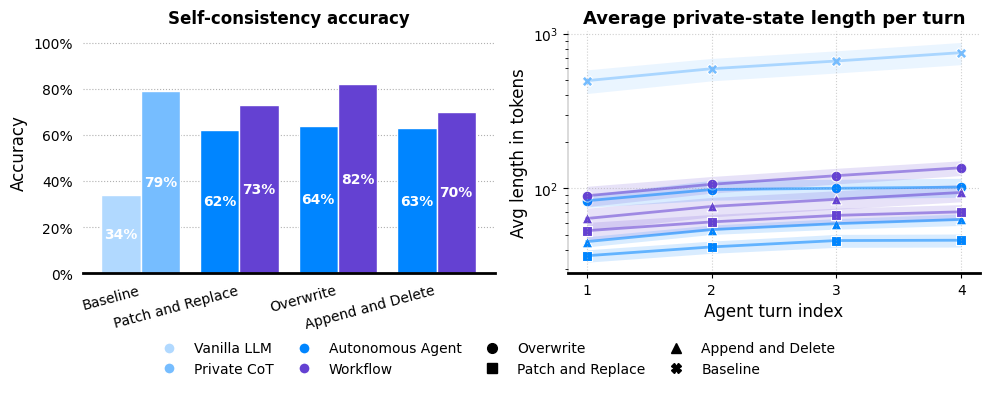

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

# --- Visual palette (keep your colors) ---
PALETTE_LIST = [
    "#b1d9ff", "#76bdff", "#3ba1ff", "#0085ff",
    "#6441d2", "#004bba", "#48a5fb", "#cce6ff",
]

FAMILY_COLORS = {
    "Vanilla LLM": PALETTE_LIST[0],
    "Private CoT": PALETTE_LIST[1],
    "Mem0": PALETTE_LIST[2],
    "Autonomous Agent": PALETTE_LIST[3],
    "Workflow": PALETTE_LIST[4],
}

STRATEGY_ORDER = ["Patch and Replace", "Overwrite", "Append and Delete"]

# Map agent -> (family, strategy) — accept both with and without `_agent`
_AGENT_MAP = {
    # baselines
    "vanilla_llm": ("Vanilla LLM", "Baseline"),
    "vanilla_llm_agent": ("Vanilla LLM", "Baseline"),
    "private_cot": ("Private CoT", "Baseline"),
    "private_cot_agent": ("Private CoT", "Baseline"),
    # "mem0_agent": ("Mem0", "Baseline"),
    # autonomous (reactmem)
    "reactmem_overwrite": ("Autonomous Agent", "Overwrite"),
    "reactmem_overwrite_agent": ("Autonomous Agent", "Overwrite"),
    "reactmem_patch_and_replace": ("Autonomous Agent", "Patch and Replace"),
    "reactmem_patch_and_replace_agent": ("Autonomous Agent", "Patch and Replace"),
    "reactmem_append_and_delete": ("Autonomous Agent", "Append and Delete"),
    "reactmem_append_and_delete_agent": ("Autonomous Agent", "Append and Delete"),
    # workflows
    "workflow_overwrite": ("Workflow", "Overwrite"),
    "workflow_overwrite_agent": ("Workflow", "Overwrite"),
    "workflow_patch_and_replace": ("Workflow", "Patch and Replace"),
    "workflow_patch_and_replace_agent": ("Workflow", "Patch and Replace"),
    "workflow_append_and_delete": ("Workflow", "Append and Delete"),
    "workflow_append_and_delete_agent": ("Workflow", "Append and Delete"),
}

def _norm_agent_key(a: str) -> str:
    if not isinstance(a, str):
        return str(a)
    s = a.strip().lower()
    s = re.sub(r"\s+", "_", s)
    s = re.sub(r"_agent$", "", s)
    if s in _AGENT_MAP: return s
    if f"{s}_agent" in _AGENT_MAP: return f"{s}_agent"
    return s

def _agent_family(agent: str) -> str:
    key = _norm_agent_key(agent)
    return _AGENT_MAP.get(key, (agent, ""))[0]

def _agent_strategy(agent: str) -> str:
    key = _norm_agent_key(agent)
    return _AGENT_MAP.get(key, ("", "Baseline"))[1]

def _nice_axes_style(ax, grid_axis="y"):
    ax.set_xlabel(""); ax.set_ylabel("")
    ax.tick_params(left=False, bottom=False)
    ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
    if grid_axis == "y":
        ax.spines["left"].set_visible(False); ax.spines["bottom"].set_linewidth(2)
        ax.yaxis.grid(True, which="major", linestyle=":")
    else:
        ax.spines["bottom"].set_visible(False); ax.spines["left"].set_linewidth(2)
        ax.xaxis.grid(True, which="major", linestyle=":")
    ax.set_axisbelow(True)

def _add_value_labels(ax, min_abs_height=0.005, inside=True):
    for rect in ax.patches:
        h = rect.get_height()
        if abs(h) >= min_abs_height:
            x = rect.get_x() + rect.get_width()/2.0
            y = rect.get_y() + h/2.0 if inside else h
            ax.text(x, y if inside else h, f"{h:.0%}",
                    fontsize=10, ha="center",
                    va="center" if inside else "bottom",
                    color="white", weight="bold")

# ---------- Plot A (accuracy) on given ax, no legend ----------
def _plot_accuracy_on_ax(evaluations: pd.DataFrame, ax: plt.Axes):
    df = evaluations.copy()
    df = df[df["agent"].apply(lambda a: _norm_agent_key(a) in _AGENT_MAP)].copy()
    df["family"]   = df["agent"].map(_agent_family)
    df["strategy"] = df["agent"].map(_agent_strategy)

    g = (
        df.groupby(["model","agent","family","strategy"], as_index=False)["revealed_yes"].mean()
          .groupby(["family","strategy"], as_index=False)["revealed_yes"].mean()
    )

    clusters = ["Baseline"] + STRATEGY_ORDER
    x_pos = {name: i for i, name in enumerate(clusters)}

    # Baselines
    baseline_fams = ["Vanilla LLM", "Private CoT"]
    baseline_vals = []
    for fam in baseline_fams:
        v = g.loc[(g["family"] == fam) & (g["strategy"] == "Baseline"), "revealed_yes"]
        if not v.empty:
            baseline_vals.append((fam, float(v.iloc[0])))

    cluster_width = 0.8
    if baseline_vals:
        n = len(baseline_vals)
        bar_w = cluster_width / max(n,1)
        offs  = np.arange(n)*bar_w - (cluster_width - bar_w)/2.0
        for off, (fam, v) in zip(offs, baseline_vals):
            ax.bar(x_pos["Baseline"]+off, v, width=bar_w,
                   color=FAMILY_COLORS[fam], edgecolor="white")

    # Strategy clusters
    for s in STRATEGY_ORDER:
        fams_here, vals_here = [], []
        for fam in ["Autonomous Agent","Workflow"]:
            v = g.loc[(g["family"] == fam) & (g["strategy"] == s), "revealed_yes"]
            if not v.empty:
                fams_here.append(fam); vals_here.append(float(v.iloc[0]))
        if not fams_here: continue
        n = len(fams_here); bar_w = cluster_width/n
        offs = np.arange(n)*bar_w - (cluster_width - bar_w)/2.0
        for off, fam, v in zip(offs, fams_here, vals_here):
            ax.bar(x_pos[s]+off, v, width=bar_w,
                   color=FAMILY_COLORS.get(fam, "#888"), edgecolor="white")

    ax.set_xticks([x_pos[n] for n in clusters])
    ax.set_xticklabels(clusters, rotation=15, ha="right")
    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
                  labels=["0%","20%","40%","60%","80%","100%"])
    _nice_axes_style(ax, grid_axis="y"); ax.set_ylim(0.0, 1.05)
    _add_value_labels(ax)
    ax.set_title("Self-consistency accuracy", pad=6, fontweight="bold")
    ax.set_ylabel("Accuracy", fontsize=12)

# ---------- Plot B (avg private-state length) on given ax, no legend ----------
def build_private_len_long(interaction_logs: pd.DataFrame, drop_zero=True, max_turns=None):
    df = interaction_logs.copy()
    if "private_state_lengths" not in df.columns:
        raise ValueError("Expected 'private_state_lengths' in interaction_logs.")
    df["episode_id"] = df.get("filepath", df.index)
    df["turn_idx_list"] = df["private_state_lengths"].apply(
        lambda L: list(range(1, len(L)+1)) if isinstance(L, (list, tuple)) else []
    )
    df_long = df.explode(["private_state_lengths","turn_idx_list"], ignore_index=True)
    df_long = df_long.rename(columns={"private_state_lengths":"length", "turn_idx_list":"turn_idx"})
    df_long["length"] = pd.to_numeric(df_long["length"], errors="coerce").fillna(0).astype(int)
    df_long["turn_idx"] = pd.to_numeric(df_long["turn_idx"], errors="coerce").astype("Int64")
    if drop_zero: df_long = df_long[df_long["length"] > 0]
    if max_turns is not None:
        df_long = df_long[df_long["turn_idx"].notna() & (df_long["turn_idx"] <= max_turns)]
    df_long["family"]   = df_long["agent"].map(_agent_family)
    df_long["strategy"] = df_long["agent"].map(_agent_strategy)
    df_long = df_long[df_long["turn_idx"].notna()].copy()
    df_long["turn_idx"] = df_long["turn_idx"].astype(int)
    return df_long

def aggregate_per_turn_agent(interaction_logs, drop_zero=True, max_turns=None):
    df = build_private_len_long(interaction_logs, drop_zero=drop_zero, max_turns=max_turns)
    grp = (df.groupby(["agent","family","strategy","turn_idx"])
             .agg(mean_len=("length","mean"),
                  std_len=("length","std"),
                  N=("length","size"))
             .reset_index())
    grp["sem"] = grp["std_len"] / np.sqrt(grp["N"].clip(lower=1))
    grp["ci"]  = 1.96 * grp["sem"].fillna(0)
    grp["lo"]  = (grp["mean_len"] - grp["ci"]).clip(lower=0)
    grp["hi"]  = grp["mean_len"] + grp["ci"]
    return grp

def _plot_private_len_on_ax(interaction_logs: pd.DataFrame, ax: plt.Axes,
                            drop_zero=True, max_turns=None, annotate_last=False, min_sep=15):
    df = aggregate_per_turn_agent(interaction_logs, drop_zero=drop_zero, max_turns=max_turns)
    if df.empty:
        ax.text(0.5, 0.5, "No private-state lengths to plot.", ha="center", va="center")
        return

    marker_map = {"Baseline":"X","Overwrite":"o","Patch and Replace":"s","Append and Delete":"^"}

    for agent, d in df.groupby("agent"):
        fam   = d["family"].iloc[0]
        strat = d["strategy"].iloc[0]
        color = FAMILY_COLORS.get(fam, "#888888")
        marker = marker_map.get(strat, "o")
        d = d.sort_values("turn_idx")
        ax.fill_between(d["turn_idx"], d["lo"], d["hi"], alpha=0.15, color=color, linewidth=0)
        ax.plot(d["turn_idx"], d["mean_len"], "-", color=color, linewidth=2, alpha=0.55)
        ax.scatter(d["turn_idx"], d["mean_len"], s=60, color=color, marker=marker,
                   edgecolor="white", linewidth=0.8)

    ax.set_xlabel("Agent turn index", fontsize=12)
    ax.set_ylabel("Avg length in tokens", fontsize=12)
    ax.set_title("Average private-state length per turn", fontweight="bold", fontsize=13)
    ax.grid(True, linestyle=":", alpha=0.6)
    ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_linewidth(2); ax.spines["left"].set_linewidth(0.2)
    ax.set_yscale("log")
    max_turn = int(df["turn_idx"].max())
    ax.set_xticks(range(1, max_turn+1))

# ---------- Combined figure with one legend at bottom ----------
def plot_accuracy_and_private_len_side_by_side(
    evaluations: pd.DataFrame,
    interaction_logs: pd.DataFrame,
    drop_zero=True,
    max_turns=None,
    figsize=(10, 4),
):
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # Left: Accuracy
    _plot_accuracy_on_ax(evaluations, axes[0])

    # Right: Private-state length
    _plot_private_len_on_ax(interaction_logs, axes[1],
                            drop_zero=drop_zero, max_turns=max_turns, annotate_last=False)

    # ----- Build a single combined legend (families + strategies) -----
    # Family (color) handles
    fam_labels_present = []
    # Derive present families from either dataset
    fams_from_eval = evaluations["agent"].apply(_agent_family).unique() if "agent" in evaluations.columns else []
    try:
        fams_from_logs = interaction_logs["agent"].apply(_agent_family).unique()
    except Exception:
        fams_from_logs = []
    present_fams = []
    for f in ["Vanilla LLM","Private CoT","Autonomous Agent","Workflow"]:
        if (f in fams_from_eval) or (f in fams_from_logs):
            present_fams.append(f)

    fam_handles = [
        plt.Line2D([0],[0], marker='o', linestyle='none',
                   markerfacecolor=FAMILY_COLORS[f], markeredgecolor="white",
                   markersize=8, label=f)
        for f in present_fams
    ]

    # Strategy (marker) handles — use black proxies
    strat_map = {"Overwrite":"o","Patch and Replace":"s","Append and Delete":"^","Baseline":"X"}
    strat_labels = ["Overwrite", "Patch and Replace", "Append and Delete", "Baseline"]
    strat_handles = [
        plt.Line2D([0],[0], marker=mk, linestyle='none',
                   markerfacecolor="black", markeredgecolor="black",
                   markersize=7, label=lab)
        for lab, mk in strat_map.items()
    ]

    # Optional group headers (non-drawing) to visually separate
    header_family  = plt.Line2D([], [], linestyle='none', label="Families (colors)")
    header_strategy= plt.Line2D([], [], linestyle='none', label="Strategies (markers)")

    handles = [header_family] + fam_handles + [header_strategy] + strat_handles
    handles = fam_handles + strat_handles
    labels  = [h.get_label() for h in handles]

    # Place legend at bottom center
    fig.legend(handles, labels, loc="lower center", ncol=max(3, len(handles)//2),
               frameon=False, borderaxespad=0.8, handletextpad=0.8, columnspacing=1.2)

    # Make room for legend
    plt.tight_layout(rect=[0, 0.12, 1, 1])
    plt.show()

# --- Usage ---
evaluations_sub = evaluations[evaluations["game"] == "diagnosis_simulator_sct"]
interaction_logs_sub = interaction_logs[interaction_logs["game"] == "diagnosis_simulator_sct"]
plot_accuracy_and_private_len_side_by_side(evaluations_sub, interaction_logs_sub, drop_zero=True, max_turns=12)

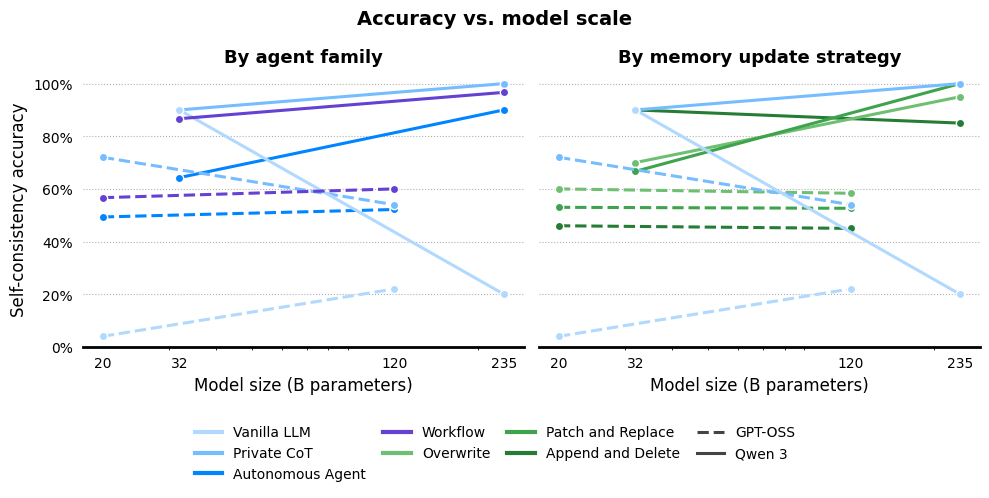

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import re

# --- Visual palette (keep your blues) ---
PALETTE_LIST = [
    "#b1d9ff", "#76bdff", "#3ba1ff", "#0085ff",
    "#6441d2", "#004bba", "#48a5fb", "#cce6ff",
]

FAMILY_COLORS = {
    "Vanilla LLM": PALETTE_LIST[0],
    "Private CoT": PALETTE_LIST[1],
    "Autonomous Agent": PALETTE_LIST[3],
    "Workflow": PALETTE_LIST[4],
}

BASELINE_COLORS = {
    "Vanilla LLM": PALETTE_LIST[0],
    "Private CoT": PALETTE_LIST[1],
}

# Three greens for update strategies
STRATEGY_COLORS = {
    "Overwrite":          "#6fbf73",
    "Patch and Replace":  "#3ea34d",
    "Append and Delete":  "#257c35",
}

# Agent -> (family, strategy)
_AGENT_MAP = {
    # baselines
    "vanilla_llm_agent": ("Vanilla LLM", "Baseline"),
    "private_cot_agent": ("Private CoT", "Baseline"),
    # autonomous (reactmem)
    "reactmem_overwrite_agent": ("Autonomous Agent", "Overwrite"),
    "reactmem_patch_and_replace_agent": ("Autonomous Agent", "Patch and Replace"),
    "reactmem_append_and_delete_agent": ("Autonomous Agent", "Append and Delete"),
    # workflows
    "workflow_overwrite_agent": ("Workflow", "Overwrite"),
    "workflow_patch_and_replace_agent": ("Workflow", "Patch and Replace"),
    "workflow_append_and_delete_agent": ("Workflow", "Append and Delete"),
}

# Model -> size in billions
_MODEL_SIZE = {
    "gpt_oss_20b_openrouter": 20,
    "gpt_oss_120b_openrouter": 120,
    "qwen3_32b_openrouter": 32,
    "qwen3_235b_openrouter": 235,
}

# Model family -> line style
_MODEL_FAMILY_LS = {
    "Qwen 3": "-",
    "GPT-OSS": "--",
}

def _model_family(model: str) -> str:
    m = str(model).lower()
    if "qwen3" in m:   return "Qwen 3"
    if "gpt_oss" in m: return "GPT-OSS"
    return "Other"

def _nice_axes_style(ax, grid_axis="y"):
    ax.tick_params(left=False, bottom=False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    if grid_axis == "y":
        ax.spines["left"].set_visible(False)
        ax.spines["bottom"].set_linewidth(2)
        ax.yaxis.grid(True, which="major", linestyle=":")
    else:
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_linewidth(2)
        ax.xaxis.grid(True, which="major", linestyle=":")
    ax.set_axisbelow(True)

# ---------- LEFT: plot by AGENT FAMILY (colors = FAMILY_COLORS; style = model family) ----------
def _plot_scale_by_family_on_ax(evaluations: pd.DataFrame, ax: plt.Axes,
                                xlog=True, xticks=None):
    df = evaluations.copy()
    if "model_size" not in df.columns:
        df["model_size"] = df["model"].map(_MODEL_SIZE)
    df = df[df["agent"].isin(_AGENT_MAP.keys())].copy()
    df = df[df["model_size"].notna()].copy()
    df["family"] = df["agent"].map(lambda a: _AGENT_MAP[a][0])
    df["model_family"] = df["model"].map(_model_family)

    agg = (df.groupby(["model_family","model_size","family"], as_index=False)["revealed_yes"]
             .mean())
    if xticks is None:
        xticks = sorted(agg["model_size"].unique().tolist())

    present_families = set()
    present_model_fams = set()

    for (fam, mf), d in agg.groupby(["family","model_family"]):
        d = d.sort_values("model_size")
        color = FAMILY_COLORS.get(fam, "#888888")
        ls = _MODEL_FAMILY_LS.get(mf, "-.")
        ax.plot(
            d["model_size"], d["revealed_yes"],
            linestyle=ls, linewidth=2.2,
            marker="o", markersize=6,
            color=color, markeredgecolor="white",
        )
        present_families.add(fam)
        present_model_fams.add(mf)

    if xlog:
        ax.set_xscale("log", base=10)
        ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.set_xticks(xticks)
    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
                  labels=["0%","20%","40%","60%","80%","100%"])
    ax.set_xlabel("Model size (B parameters)", fontsize=12)
    ax.set_ylabel("Self-consistency accuracy", fontsize=12)
    ax.set_title("By agent family", pad=6, fontsize=13, fontweight="bold")
    _nice_axes_style(ax, grid_axis="y")
    ax.set_ylim(0.0, 1.05)

    return sorted(present_families), sorted(present_model_fams)

# ---------- RIGHT: plot by UPDATE STRATEGY (colors = greens; style = model family) ----------
def _plot_scale_by_strategy_on_ax(evaluations: pd.DataFrame, ax: plt.Axes,
                                  xlog=True, xticks=None):
    df = evaluations.copy()
    if "model_size" not in df.columns:
        df["model_size"] = df["model"].map(_MODEL_SIZE)
    df = df[df["agent"].isin(_AGENT_MAP.keys())].copy()
    df = df[df["model_size"].notna()].copy()

    df["family"] = df["agent"].map(lambda a: _AGENT_MAP[a][0])
    df["strategy"] = df["agent"].map(lambda a: _AGENT_MAP[a][1])
    df["model_family"] = df["model"].map(_model_family)
    # group label: baselines keep family name; others use strategy (averaging Autonomous+Workflow)
    df["group"] = np.where(df["strategy"] == "Baseline", df["family"], df["strategy"])

    agg = (df.groupby(["model_family","model_size","group"], as_index=False)["revealed_yes"]
             .mean())

    if xticks is None:
        xticks = sorted(agg["model_size"].unique().tolist())

    def _group_color(g: str) -> str:
        if g in BASELINE_COLORS:
            return BASELINE_COLORS[g]
        return STRATEGY_COLORS.get(g, "#888888")

    present_groups = set()
    present_model_fams = set()

    for (grp, mf), d in agg.groupby(["group","model_family"]):
        d = d.sort_values("model_size")
        color = _group_color(grp)
        ls = _MODEL_FAMILY_LS.get(mf, "-.")
        ax.plot(
            d["model_size"], d["revealed_yes"],
            linestyle=ls, linewidth=2.2,
            marker="o", markersize=6,
            color=color, markeredgecolor="white",
        )
        present_groups.add(grp)
        present_model_fams.add(mf)

    if xlog:
        ax.set_xscale("log", base=10)
        ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.set_xticks(xticks)
    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
                  labels=["0%","20%","40%","60%","80%","100%"])
    ax.set_xlabel("Model size (B parameters)", fontsize=12)
    # ax.set_ylabel("Self-consistency accuracy", fontsize=12)
    ax.set_title("By memory update strategy", pad=6, fontsize=13, fontweight="bold")
    _nice_axes_style(ax, grid_axis="y")
    ax.set_ylim(0.0, 1.05)

    return sorted(present_groups), sorted(present_model_fams)

# ---------- COMBINED FIGURE WITH ONE LEGEND AT THE BOTTOM ----------
def plot_scale_family_and_strategy_side_by_side(
    evaluations: pd.DataFrame,
    xlog: bool = True,
    xticks: list | None = None,
    figsize=(10, 5),
):
    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True)

    fams_left,   mfs_left   = _plot_scale_by_family_on_ax(evaluations, axes[0], xlog=xlog, xticks=xticks)
    groups_right, mfs_right = _plot_scale_by_strategy_on_ax(evaluations, axes[1], xlog=xlog, xticks=xticks)

    # ----- Build unified legend (bottom) -----
    # 1) Colors for left families
    fam_handles = []
    fam_labels  = []
    for fam in ["Vanilla LLM", "Private CoT", "Autonomous Agent", "Workflow"]:
        if fam in fams_left:
            h, = plt.plot([], [], color=FAMILY_COLORS[fam], linewidth=3, label=fam)
            fam_handles.append(h); fam_labels.append(fam)

    # 2) Colors for right groups (baselines + strategies)
    group_order = ["Overwrite", "Patch and Replace", "Append and Delete"]
    group_handles, group_labels = [], []
    def _group_color(g):
        return BASELINE_COLORS.get(g, STRATEGY_COLORS.get(g, "#888888"))
    for g in group_order:
        if g in groups_right:
            h, = plt.plot([], [], color=_group_color(g), linewidth=3, label=g)
            group_handles.append(h); group_labels.append(g)

    # 3) Line-style legend for model families (union of both subplots)
    mf_all = sorted(set(mfs_left) | set(mfs_right))
    mf_handles, mf_labels = [], []
    for mf in mf_all:
        ls = _MODEL_FAMILY_LS.get(mf, "-.")
        h, = plt.plot([], [], color="#444444", linestyle=ls, linewidth=2.2, label=mf)
        mf_handles.append(h); mf_labels.append(mf)

    # Optional headers (non-drawing) to separate sections
    header_left   = plt.Line2D([], [], linestyle='none', label="Left: Agent families")
    header_right  = plt.Line2D([], [], linestyle='none', label="Right: Baselines & strategies")
    header_styles = plt.Line2D([], [], linestyle='none', label="Line styles: Model families")

    # handles = [header_left] + fam_handles + [header_right] + group_handles + [header_styles] + mf_handles
    handles = fam_handles + group_handles + mf_handles
    labels  = [h.get_label() for h in handles]

    fig.suptitle("Accuracy vs. model scale", fontsize=14, fontweight="bold")

    # Layout: make room at the bottom
    plt.tight_layout(rect=[0, 0.18, 1, 1])
    fig.legend(handles, labels, loc="lower center",
               ncol=max(4, len(handles)//2),
               frameon=False, borderaxespad=0.8, handletextpad=0.8, columnspacing=1.2)

    plt.show()

# --- Usage ---
evaluations_sub = evaluations[evaluations["game"] == "diagnosis_simulator_sct"]
plot_scale_family_and_strategy_side_by_side(evaluations_sub, xlog=True)

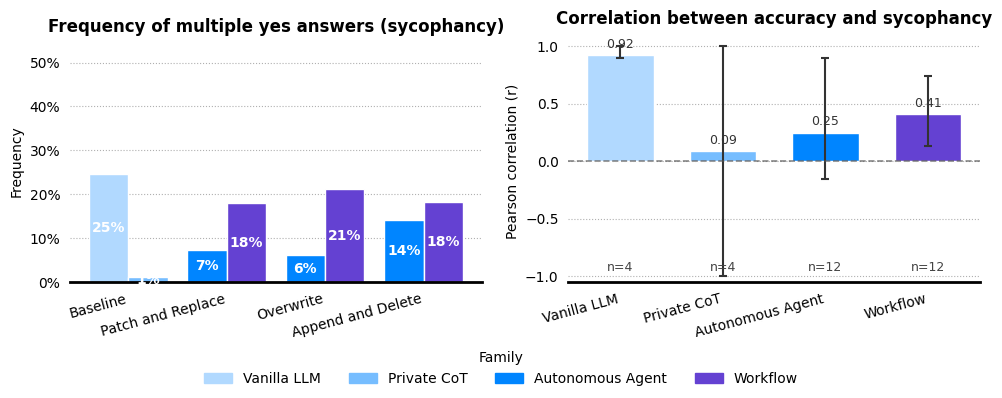

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# (reuse your palettes, FAMILY_COLORS, STRATEGY_ORDER, _AGENT_MAP, _nice_axes_style, _add_value_labels from your snippets)

def plot_sycophancy_and_correlation(evaluations: pd.DataFrame, invert: bool = True,
                                    n_boot: int = 5000, seed: int = 0):
    """
    Create a side-by-side figure:
      Left: Selectivity/Sycophancy grouped bar plot.
      Right: Correlation between accuracy and sycophancy (Pearson r with 95% CI).
    """

    # ---------------- LEFT PANEL (sycophancy/selectivity) ----------------
    df = evaluations.copy()
    df = df[df["agent"].isin(_AGENT_MAP.keys())].copy()
    df["family"] = df["agent"].map(lambda a: _AGENT_MAP[a][0])
    df["strategy"] = df["agent"].map(lambda a: _AGENT_MAP[a][1])

    metric = "more_than_one_yes"
    g = (
        df.groupby(["model", "agent", "family", "strategy"], as_index=False)[metric]
          .mean()
          .groupby(["family", "strategy"], as_index=False)[metric]
          .mean()
    )

    if invert:
        g["value"] = 1.0 - g[metric]
        left_title = "Selectivity (1 − fraction of trials with >1 'yes')"
        left_ylabel = "Selectivity (higher is better)"
    else:
        g["value"] = g[metric]
        left_title = "Frequency of multiple yes answers (sycophancy)"
        left_ylabel = "Frequency"

    clusters = ["Baseline"] + STRATEGY_ORDER
    x_pos = {name: i for i, name in enumerate(clusters)}

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    # --- Baseline cluster
    baseline_fams = ["Vanilla LLM", "Private CoT"]
    base_vals = []
    for fam in baseline_fams:
        v = g.loc[(g["family"] == fam) & (g["strategy"] == "Baseline"), "value"]
        if not v.empty:
            base_vals.append((fam, float(v.iloc[0])))

    if base_vals:
        n = len(base_vals)
        cluster_width = 0.8
        bar_w = cluster_width / n
        offsets = np.arange(n) * bar_w - (cluster_width - bar_w) / 2.0
        for (off, (fam, v)) in zip(offsets, base_vals):
            ax1.bar(
                x_pos["Baseline"] + off,
                v,
                width=bar_w,
                color=FAMILY_COLORS[fam],
                edgecolor="white",
                label=fam,
            )

    # --- Strategy clusters
    for s in STRATEGY_ORDER:
        fams_here, vals_here = [], []
        for fam in ["Autonomous Agent", "Workflow"]:
            v = g.loc[(g["family"] == fam) & (g["strategy"] == s), "value"]
            if not v.empty:
                fams_here.append(fam)
                vals_here.append(float(v.iloc[0]))
        if not fams_here:
            continue
        n = len(fams_here)
        cluster_width = 0.8
        bar_w = cluster_width / n
        offsets = np.arange(n) * bar_w - (cluster_width - bar_w) / 2.0
        for off, fam, v in zip(offsets, fams_here, vals_here):
            ax1.bar(
                x_pos[s] + off,
                v,
                width=bar_w,
                color=FAMILY_COLORS[fam],
                edgecolor="white",
                label=fam,
            )

    ax1.set_xticks([x_pos[name] for name in clusters])
    ax1.set_xticklabels(clusters, rotation=15, ha="right")
    ax1.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5], labels=["0%", "10%", "20%", "30%", "40%", "50%",])
    _nice_axes_style(ax1, grid_axis="y")
    ax1.set_ylim(0.0, 0.55)
    _add_value_labels(ax1)
    ax1.set_title(left_title, pad=6, fontweight="bold")
    ax1.set_ylabel(left_ylabel)

    # ---------------- RIGHT PANEL (correlation) ----------------
    needed = {"model","agent","revealed_yes","more_than_one_yes"}
    if not needed.issubset(evaluations.columns):
        raise ValueError(f"Missing required columns: {needed - set(evaluations.columns)}")

    df = evaluations[evaluations["agent"].isin(_AGENT_MAP.keys())].copy()
    df["family"] = df["agent"].map(lambda a: _AGENT_MAP[a][0])

    pts = (df.groupby(["family","agent","model"], as_index=False)
             .agg(revealed_yes=("revealed_yes","mean"),
                  more_than_one_yes=("more_than_one_yes","mean")))

    rng = np.random.default_rng(seed)
    rows = []
    for fam, d in pts.groupby("family"):
        x = d["revealed_yes"].to_numpy()
        y = d["more_than_one_yes"].to_numpy()
        if len(x) < 2 or np.std(x) == 0 or np.std(y) == 0:
            r, lo, hi, is_nan = np.nan, np.nan, np.nan, True
        else:
            r, _ = pearsonr(x, y)
            n = len(d)
            boot = []
            if n >= 3:
                for _ in range(n_boot):
                    idx = rng.integers(0, n, size=n)
                    xb, yb = x[idx], y[idx]
                    if np.std(xb) > 0 and np.std(yb) > 0:
                        rb, _ = pearsonr(xb, yb)
                        boot.append(rb)
            if boot:
                lo, hi = np.percentile(boot, [2.5, 97.5])
            else:
                lo, hi = np.nan, np.nan
            is_nan = False
        rows.append({"family": fam, "r": r, "lo": lo, "hi": hi,
                     "is_nan": is_nan, "n_points": len(d)})

    corr_df = pd.DataFrame(rows)
    fam_order = ["Vanilla LLM", "Private CoT", "Autonomous Agent", "Workflow"]
    corr_df = corr_df.set_index("family").reindex(fam_order).reset_index()

    corr_df["r_plot"]  = corr_df["r"].fillna(0.0)
    corr_df["lo_plot"] = np.where(corr_df["is_nan"], corr_df["r_plot"], corr_df["lo"])
    corr_df["hi_plot"] = np.where(corr_df["is_nan"], corr_df["r_plot"], corr_df["hi"])

    x = np.arange(len(corr_df))
    for i, row in corr_df.iterrows():
        fam   = row["family"]
        color = FAMILY_COLORS.get(fam, "#888888")
        ax2.bar(
            x[i], row["r_plot"],
            color=color, edgecolor="white", width=0.65,
            hatch="///" if row["is_nan"] else None,
            alpha=0.55 if row["is_nan"] else 1.0,
        )
        label_txt = "undef" if row["is_nan"] else f"{row['r_plot']:.2f}"
        ax2.text(x[i], row["r_plot"] + (0.04 if row["r_plot"] >= 0 else -0.06),
                 label_txt, ha="center", va="bottom" if row["r_plot"]>=0 else "top",
                 fontsize=9, color="#333333")

    vals = corr_df["r_plot"].to_numpy()
    yerr = np.vstack([
        np.where(corr_df["is_nan"], 0.0, vals - corr_df["lo_plot"].to_numpy()),
        np.where(corr_df["is_nan"], 0.0, corr_df["hi_plot"].to_numpy() - vals),
    ])
    ax2.errorbar(x, vals, yerr=yerr, fmt="none", ecolor="#333333",
                 elinewidth=1.5, capsize=3, capthick=1.5)

    ax2.axhline(0, color="#555555", linewidth=1.2, linestyle="--", alpha=0.7)
    ax2.set_xticks(x)
    ax2.set_xticklabels(corr_df["family"], rotation=15, ha="right")
    ax2.set_ylabel("Pearson correlation (r)")
    ax2.set_title("Correlation between accuracy and sycophancy", fontweight="bold", pad=12)
    _nice_axes_style(ax2, grid_axis="y")
    ax2.set_ylim(-1.05, 1.05)

    for i, n in enumerate(corr_df["n_points"].to_numpy()):
        ax2.text(x[i], -0.98, f"n={int(n)}", ha="center", va="bottom", fontsize=9, color="#444444")

    # ---------------- Shared legend ----------------
    handles = [plt.Rectangle((0,0),1,1,color=FAMILY_COLORS[f]) for f in fam_order]
    labels  = fam_order
    fig.legend(handles, labels, loc="lower center", ncol=len(fam_order), frameon=False, title="Family")

    # plt.tight_layout(rect=[0,0,1.2,0.92])
    plt.tight_layout(rect=[0, 0.1, 1, 1])
    # plt.tight_layout(rect=[0,0,0.92,1])
    plt.show()

# Example usage:
# evaluations_sub = evaluations[evaluations["game"] == "diagnosis_simulator_sct"]
plot_sycophancy_and_correlation(evaluations, invert=False, n_boot=5000, seed=0)

## Final Figures with Mem0

In [38]:
# --- Visual palette (keep your colors) ---
PALETTE_LIST = [
    "#b1d9ff", "#76bdff", "#3ba1ff", "#0085ff",
    "#6441d2", "#004bba", "#48a5fb", "#cce6ff",
    "#FF4D00", "#FFDE21"
]

FAMILY_COLORS = {
    "Vanilla LLM": PALETTE_LIST[0],
    "Private CoT": PALETTE_LIST[1],
    "Mem0": PALETTE_LIST[-2],
    "A-Mem": PALETTE_LIST[-1],
    "Letta": PALETTE_LIST[-3],
    "Autonomous Agent": PALETTE_LIST[3],
    "Workflow": PALETTE_LIST[4],
}

STRATEGY_ORDER = ["Patch and Replace", "Overwrite", "Append and Delete"]

BG_COLORS = ['#ffffff', '#fafafa']

BASELINE_COLORS = {
    "Vanilla LLM": PALETTE_LIST[0],
    "Private CoT": PALETTE_LIST[1],
    "Mem0": PALETTE_LIST[-2],
    "A-Mem": PALETTE_LIST[-1],
    "Letta": PALETTE_LIST[-3],
}

# Three greens for update strategies
STRATEGY_COLORS = {
    "Overwrite":          "#6fbf73",
    "Patch and Replace":  "#3ea34d",
    "Append and Delete":  "#257c35",
}

# Agent -> (family, strategy)
_AGENT_MAP = {
    # baselines
    "vanilla_llm_agent": ("Vanilla LLM", "Baseline"),
    "private_cot_agent": ("Private CoT", "Baseline"),
    "mem0_agent": ("Mem0", "Baseline"),
    "amem_agent": ("A-Mem", "Baseline"),
    "letta_agent": ("Letta", "Baseline"),
    # autonomous (reactmem)
    "reactmem_overwrite_agent": ("Autonomous Agent", "Overwrite"),
    "reactmem_patch_and_replace_agent": ("Autonomous Agent", "Patch and Replace"),
    "reactmem_append_and_delete_agent": ("Autonomous Agent", "Append and Delete"),
    # workflows
    "workflow_overwrite_agent": ("Workflow", "Overwrite"),
    "workflow_patch_and_replace_agent": ("Workflow", "Patch and Replace"),
    "workflow_append_and_delete_agent": ("Workflow", "Append and Delete"),
}

_MODEL_NAME = {
    "gpt_oss_20b_openrouter": "GPT-OSS 20B",
    "gpt_oss_120b_openrouter": "GPT-OSS 120B",
    "qwen3_32b_openrouter": "Qwen3 32B",
    "qwen3_235b_openrouter": "Qwen3 235B",
}

_GAME_NAME = {
    "hangman_sct": "Hangman",
    "diagnosis_simulator_sct": "Diagnosis Simulator",
}

# Model -> size in billions
_MODEL_SIZE = {
    "gpt_oss_20b_openrouter": 20,
    "gpt_oss_120b_openrouter": 120,
    "qwen3_32b_openrouter": 32,
    "qwen3_235b_openrouter": 235,
}

# Model family -> line style
_MODEL_FAMILY_LS = {
    "Qwen 3": "-",
    "GPT-OSS": "--",
}

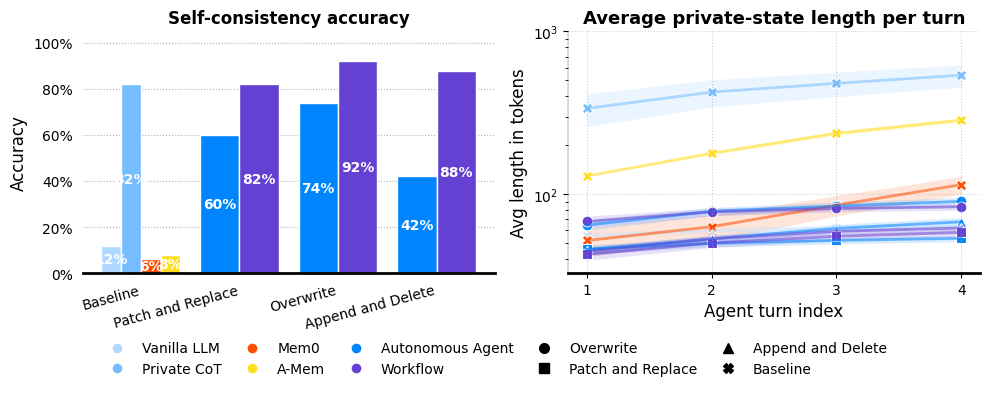

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re


def _norm_agent_key(a: str) -> str:
    if not isinstance(a, str):
        return str(a)
    s = a.strip().lower()
    s = re.sub(r"\s+", "_", s)
    s = re.sub(r"_agent$", "", s)
    if s in _AGENT_MAP: return s
    if f"{s}_agent" in _AGENT_MAP: return f"{s}_agent"
    return s

def _agent_family(agent: str) -> str:
    key = _norm_agent_key(agent)
    return _AGENT_MAP.get(key, (agent, ""))[0]

def _agent_strategy(agent: str) -> str:
    key = _norm_agent_key(agent)
    return _AGENT_MAP.get(key, ("", "Baseline"))[1]

def _nice_axes_style(ax, grid_axis="y"):
    ax.set_xlabel(""); ax.set_ylabel("")
    ax.tick_params(left=False, bottom=False)
    ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
    if grid_axis == "y":
        ax.spines["left"].set_visible(False); ax.spines["bottom"].set_linewidth(2)
        ax.yaxis.grid(True, which="major", linestyle=":")
    else:
        ax.spines["bottom"].set_visible(False); ax.spines["left"].set_linewidth(2)
        ax.xaxis.grid(True, which="major", linestyle=":")
    ax.set_axisbelow(True)

def _add_value_labels(ax, min_abs_height=0.005, inside=True):
    for rect in ax.patches:
        h = rect.get_height()
        if abs(h) >= min_abs_height:
            x = rect.get_x() + rect.get_width()/2.0
            y = rect.get_y() + h/2.0 if inside else h
            ax.text(x, y if inside else h, f"{h:.0%}",
                    fontsize=10, ha="center",
                    va="center" if inside else "bottom",
                    color="white", weight="bold")

# ---------- Plot A (accuracy) on given ax, no legend ----------
def _plot_accuracy_on_ax(evaluations: pd.DataFrame, ax: plt.Axes):
    df = evaluations.copy()
    df = df[df["agent"].apply(lambda a: _norm_agent_key(a) in _AGENT_MAP)].copy()
    df["family"]   = df["agent"].map(_agent_family)
    df["strategy"] = df["agent"].map(_agent_strategy)

    g = (
        df.groupby(["model","agent","family","strategy"], as_index=False)["self_consistency"].mean()
          .groupby(["family","strategy"], as_index=False)["self_consistency"].mean()
    )

    clusters = ["Baseline"] + STRATEGY_ORDER
    x_pos = {name: i for i, name in enumerate(clusters)}

    # Baselines
    baseline_fams = ["Vanilla LLM", "Private CoT", "Mem0", "A-Mem"]
    baseline_vals = []
    for fam in baseline_fams:
        v = g.loc[(g["family"] == fam) & (g["strategy"] == "Baseline"), "self_consistency"]
        if not v.empty:
            baseline_vals.append((fam, float(v.iloc[0])))

    cluster_width = 0.8
    if baseline_vals:
        n = len(baseline_vals)
        bar_w = cluster_width / max(n,1)
        offs  = np.arange(n)*bar_w - (cluster_width - bar_w)/2.0
        for off, (fam, v) in zip(offs, baseline_vals):
            ax.bar(x_pos["Baseline"]+off, v, width=bar_w,
                   color=FAMILY_COLORS[fam], edgecolor="white")

    # Strategy clusters
    for s in STRATEGY_ORDER:
        fams_here, vals_here = [], []
        for fam in ["Autonomous Agent","Workflow"]:
            v = g.loc[(g["family"] == fam) & (g["strategy"] == s), "self_consistency"]
            if not v.empty:
                fams_here.append(fam); vals_here.append(float(v.iloc[0]))
        if not fams_here: continue
        n = len(fams_here); bar_w = cluster_width/n
        offs = np.arange(n)*bar_w - (cluster_width - bar_w)/2.0
        for off, fam, v in zip(offs, fams_here, vals_here):
            ax.bar(x_pos[s]+off, v, width=bar_w,
                   color=FAMILY_COLORS.get(fam, "#888"), edgecolor="white")

    ax.set_xticks([x_pos[n] for n in clusters])
    ax.set_xticklabels(clusters, rotation=15, ha="right")
    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
                  labels=["0%","20%","40%","60%","80%","100%"])
    _nice_axes_style(ax, grid_axis="y"); ax.set_ylim(0.0, 1.05)
    _add_value_labels(ax)
    ax.set_title("Self-consistency accuracy", pad=6, fontweight="bold")
    ax.set_ylabel("Accuracy", fontsize=12)

# ---------- Plot B (avg private-state length) on given ax, no legend ----------
def build_private_len_long(interaction_logs: pd.DataFrame, drop_zero=True, max_turns=None):
    df = interaction_logs.copy()
    if "private_state_lengths" not in df.columns:
        raise ValueError("Expected 'private_state_lengths' in interaction_logs.")
    df["episode_id"] = df.get("filepath", df.index)
    df["turn_idx_list"] = df["private_state_lengths"].apply(
        lambda L: list(range(1, len(L)+1)) if isinstance(L, (list, tuple)) else []
    )
    df_long = df.explode(["private_state_lengths","turn_idx_list"], ignore_index=True)
    df_long = df_long.rename(columns={"private_state_lengths":"length", "turn_idx_list":"turn_idx"})
    df_long["length"] = pd.to_numeric(df_long["length"], errors="coerce").fillna(0).astype(int)
    df_long["turn_idx"] = pd.to_numeric(df_long["turn_idx"], errors="coerce").astype("Int64")
    if drop_zero: df_long = df_long[df_long["length"] > 0]
    if max_turns is not None:
        df_long = df_long[df_long["turn_idx"].notna() & (df_long["turn_idx"] <= max_turns)]
    df_long["family"]   = df_long["agent"].map(_agent_family)
    df_long["strategy"] = df_long["agent"].map(_agent_strategy)
    df_long = df_long[df_long["turn_idx"].notna()].copy()
    df_long["turn_idx"] = df_long["turn_idx"].astype(int)
    return df_long

def aggregate_per_turn_agent(interaction_logs, drop_zero=True, max_turns=None):
    df = build_private_len_long(interaction_logs, drop_zero=drop_zero, max_turns=max_turns)
    grp = (df.groupby(["agent","family","strategy","turn_idx"])
             .agg(mean_len=("length","mean"),
                  std_len=("length","std"),
                  N=("length","size"))
             .reset_index())
    grp["sem"] = grp["std_len"] / np.sqrt(grp["N"].clip(lower=1))
    grp["ci"]  = 1.96 * grp["sem"].fillna(0)
    grp["lo"]  = (grp["mean_len"] - grp["ci"]).clip(lower=0)
    grp["hi"]  = grp["mean_len"] + grp["ci"]
    return grp

def _plot_private_len_on_ax(interaction_logs: pd.DataFrame, ax: plt.Axes,
                            drop_zero=True, max_turns=None, annotate_last=False, min_sep=15):
    df = aggregate_per_turn_agent(interaction_logs, drop_zero=drop_zero, max_turns=max_turns)
    if df.empty:
        ax.text(0.5, 0.5, "No private-state lengths to plot.", ha="center", va="center")
        return

    marker_map = {"Baseline":"X","Overwrite":"o","Patch and Replace":"s","Append and Delete":"^"}

    for agent, d in df.groupby("agent"):
        fam   = d["family"].iloc[0]
        strat = d["strategy"].iloc[0]
        color = FAMILY_COLORS.get(fam, "#888888")
        marker = marker_map.get(strat, "o")
        d = d.sort_values("turn_idx")
        ax.fill_between(d["turn_idx"], d["lo"], d["hi"], alpha=0.15, color=color, linewidth=0)
        ax.plot(d["turn_idx"], d["mean_len"], "-", color=color, linewidth=2, alpha=0.55)
        ax.scatter(d["turn_idx"], d["mean_len"], s=60, color=color, marker=marker,
                   edgecolor="white", linewidth=0.8)

    ax.set_xlabel("Agent turn index", fontsize=12)
    ax.set_ylabel("Avg length in tokens", fontsize=12)
    ax.set_title("Average private-state length per turn", fontweight="bold", fontsize=13)
    ax.grid(True, linestyle=":", alpha=0.6)
    ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_linewidth(2); ax.spines["left"].set_linewidth(0.2)
    ax.set_yscale("log")
    max_turn = int(df["turn_idx"].max())
    ax.set_xticks(range(1, max_turn+1))
    ax.set_ylim(min(df["mean_len"])-10, 1000)

# ---------- Combined figure with one legend at bottom ----------
def plot_accuracy_and_private_len_side_by_side(
    evaluations: pd.DataFrame,
    interaction_logs: pd.DataFrame,
    drop_zero=True,
    max_turns=None,
    figsize=(10, 4),
):
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # Left: Accuracy
    _plot_accuracy_on_ax(evaluations, axes[0])

    # Right: Private-state length
    _plot_private_len_on_ax(interaction_logs, axes[1],
                            drop_zero=drop_zero, max_turns=max_turns, annotate_last=False)

    # ----- Build a single combined legend (families + strategies) -----
    # Family (color) handles
    fam_labels_present = []
    # Derive present families from either dataset
    fams_from_eval = evaluations["agent"].apply(_agent_family).unique() if "agent" in evaluations.columns else []
    try:
        fams_from_logs = interaction_logs["agent"].apply(_agent_family).unique()
    except Exception:
        fams_from_logs = []
    present_fams = []
    for f in ["Vanilla LLM","Private CoT", "Mem0", "A-Mem", "Autonomous Agent","Workflow"]:
        if (f in fams_from_eval) or (f in fams_from_logs):
            present_fams.append(f)

    fam_handles = [
        plt.Line2D([0],[0], marker='o', linestyle='none',
                   markerfacecolor=FAMILY_COLORS[f], markeredgecolor="white",
                   markersize=8, label=f)
        for f in present_fams
    ]

    # Strategy (marker) handles — use black proxies
    strat_map = {"Overwrite":"o","Patch and Replace":"s","Append and Delete":"^","Baseline":"X"}
    strat_labels = ["Overwrite", "Patch and Replace", "Append and Delete", "Baseline"]
    strat_handles = [
        plt.Line2D([0],[0], marker=mk, linestyle='none',
                   markerfacecolor="black", markeredgecolor="black",
                   markersize=7, label=lab)
        for lab, mk in strat_map.items()
    ]

    # Optional group headers (non-drawing) to visually separate
    header_family  = plt.Line2D([], [], linestyle='none', label="Families (colors)")
    header_strategy= plt.Line2D([], [], linestyle='none', label="Strategies (markers)")

    handles = [header_family] + fam_handles + [header_strategy] + strat_handles
    handles = fam_handles + strat_handles
    labels  = [h.get_label() for h in handles]

    # Place legend at bottom center
    fig.legend(handles, labels, loc="lower center", ncol=max(2, len(handles)//2),
               frameon=False, borderaxespad=0.8, handletextpad=0.8, columnspacing=1.2)

    # Make room for legend
    plt.tight_layout(rect=[0, 0.12, 1, 1])
    plt.show()

# --- Usage ---
evaluations_sub = evaluations[(evaluations["game"] == "hangman_sct") & (evaluations["model"].str.contains("gpt_oss_120"))]
interaction_logs_sub = interaction_logs[(interaction_logs["game"] == "hangman_sct") & (interaction_logs["model"].str.contains("gpt_oss"))]
plot_accuracy_and_private_len_side_by_side(evaluations_sub, interaction_logs_sub, drop_zero=True, max_turns=12)

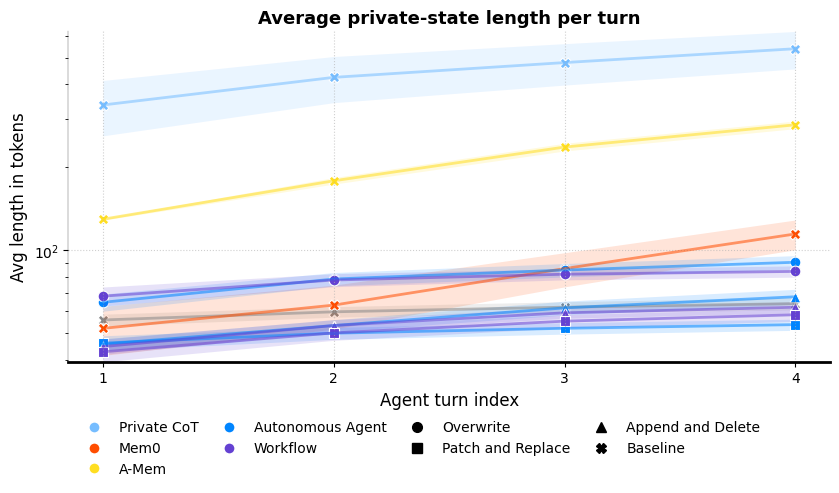

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re


# ---------- helpers ----------
def _norm_agent_key(a: str) -> str:
    if not isinstance(a, str):
        return str(a)
    s = a.strip().lower()
    s = re.sub(r"\s+", "_", s)
    s = re.sub(r"_agent$", "", s)
    if s in _AGENT_MAP: return s
    if f"{s}_agent" in _AGENT_MAP: return f"{s}_agent"
    return s

def _agent_family(agent: str) -> str:
    key = _norm_agent_key(agent)
    return _AGENT_MAP.get(key, (agent, ""))[0]

def _agent_strategy(agent: str) -> str:
    key = _norm_agent_key(agent)
    return _AGENT_MAP.get(key, ("", "Baseline"))[1]

# ---------- long-format builder ----------
def build_private_len_long(interaction_logs: pd.DataFrame, drop_zero=True, max_turns=None):
    df = interaction_logs.copy()
    if "private_state_lengths" not in df.columns:
        raise ValueError("Expected 'private_state_lengths' in interaction_logs.")
    df["episode_id"] = df.get("filepath", df.index)
    df["turn_idx_list"] = df["private_state_lengths"].apply(
        lambda L: list(range(1, len(L)+1)) if isinstance(L, (list, tuple)) else []
    )
    df_long = df.explode(["private_state_lengths","turn_idx_list"], ignore_index=True)
    df_long = df_long.rename(columns={"private_state_lengths":"length", "turn_idx_list":"turn_idx"})
    df_long["length"] = pd.to_numeric(df_long["length"], errors="coerce").fillna(0).astype(int)
    df_long["turn_idx"] = pd.to_numeric(df_long["turn_idx"], errors="coerce").astype("Int64")

    if drop_zero:
        df_long = df_long[df_long["length"] > 0]
    if max_turns is not None:
        df_long = df_long[df_long["turn_idx"].notna() & (df_long["turn_idx"] <= max_turns)]

    df_long["family"]   = df_long["agent"].map(_agent_family)
    df_long["strategy"] = df_long["agent"].map(_agent_strategy)
    df_long = df_long[df_long["turn_idx"].notna()].copy()
    df_long["turn_idx"] = df_long["turn_idx"].astype(int)
    return df_long

def aggregate_per_turn_agent(interaction_logs, drop_zero=True, max_turns=None):
    df = build_private_len_long(interaction_logs, drop_zero=drop_zero, max_turns=max_turns)
    grp = (df.groupby(["agent","family","strategy","turn_idx"])
             .agg(mean_len=("length","mean"),
                  std_len=("length","std"),
                  N=("length","size"))
             .reset_index())
    grp["sem"] = grp["std_len"] / np.sqrt(grp["N"].clip(lower=1))
    grp["ci"]  = 1.96 * grp["sem"].fillna(0)
    grp["lo"]  = (grp["mean_len"] - grp["ci"]).clip(lower=0)
    grp["hi"]  = grp["mean_len"] + grp["ci"]
    return grp

# ---------- the plot (ONE chart) ----------
def plot_private_len_only(
    interaction_logs: pd.DataFrame,
    drop_zero=True,
    max_turns=None,
    figsize=(8.5, 5.0),
):
    df = aggregate_per_turn_agent(interaction_logs, drop_zero=drop_zero, max_turns=max_turns)

    fig, ax = plt.subplots(1, 1, figsize=figsize)

    if df.empty:
        ax.text(0.5, 0.5, "No private-state lengths to plot.", ha="center", va="center")
    else:
        marker_map = {"Baseline":"X","Overwrite":"o","Patch and Replace":"s","Append and Delete":"^"}

        for agent, d in df.groupby("agent"):
            fam   = d["family"].iloc[0]
            strat = d["strategy"].iloc[0]
            color = FAMILY_COLORS.get(fam, "#888888")
            marker = marker_map.get(strat, "o")
            d = d.sort_values("turn_idx")
            ax.fill_between(d["turn_idx"], d["lo"], d["hi"], alpha=0.15, color=color, linewidth=0)
            ax.plot(d["turn_idx"], d["mean_len"], "-", color=color, linewidth=2, alpha=0.55)
            ax.scatter(d["turn_idx"], d["mean_len"], s=60, color=color, marker=marker,
                       edgecolor="white", linewidth=0.8, label=f"{fam} · {strat}")

        ax.set_xlabel("Agent turn index", fontsize=12)
        ax.set_ylabel("Avg length in tokens", fontsize=12)
        ax.set_title("Average private-state length per turn", fontweight="bold", fontsize=13)
        ax.grid(True, linestyle=":", alpha=0.6)
        ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_linewidth(2); ax.spines["left"].set_linewidth(0.2)

        ax.set_yscale("log")
        max_turn = int(df["turn_idx"].max())
        ax.set_xticks(range(1, max_turn+1))

        # Keep a sensible floor for log scale
        ymin = max(1, np.nanmin(df["lo"].values[df["lo"].values > 0]) if (df["lo"] > 0).any() else 1)
        ymax = max(df["hi"].max(), ymin*2)
        ax.set_ylim(ymin, ymax)

    # ----- Legend outside the chart (same content: families/colors + strategies/markers) -----
    # Build family handles (colors) and strategy handles (markers)
    present_fams = []
    if not df.empty:
        present_fams = [f for f in ["Vanilla LLM","Private CoT","Mem0","A-Mem","Autonomous Agent","Workflow"]
                        if f in df["family"].unique()]

    fam_handles = [
        plt.Line2D([0],[0], marker='o', linestyle='none',
                   markerfacecolor=FAMILY_COLORS[f], markeredgecolor="white",
                   markersize=8, label=f)
        for f in present_fams
    ]
    strat_map = {"Overwrite":"o","Patch and Replace":"s","Append and Delete":"^","Baseline":"X"}
    strat_handles = [
        plt.Line2D([0],[0], marker=mk, linestyle='none',
                   markerfacecolor="black", markeredgecolor="black",
                   markersize=7, label=lab)
        for lab, mk in strat_map.items()
        if (not df.empty) and (lab in df["strategy"].unique() or (lab=="Baseline" and "Baseline" in df["strategy"].unique()))
    ]

    handles = fam_handles + strat_handles
    labels  = [h.get_label() for h in handles]

    # Place legend OUTSIDE (below), centered
    fig.legend(handles, labels, loc="lower center", ncol=max(2, len(handles)//2),
               frameon=False, borderaxespad=0.8, handletextpad=0.8, columnspacing=1.2)

    # Make room for legend
    plt.tight_layout(rect=[0, 0.14, 1, 1])
    plt.show()

# --- Usage (example) ---
# interaction_logs_sub = interaction_logs[(interaction_logs["game"] == "hangman_sct") & (interaction_logs["model"].str.contains("gpt_oss"))]
plot_private_len_only(interaction_logs_sub, drop_zero=True, max_turns=12)

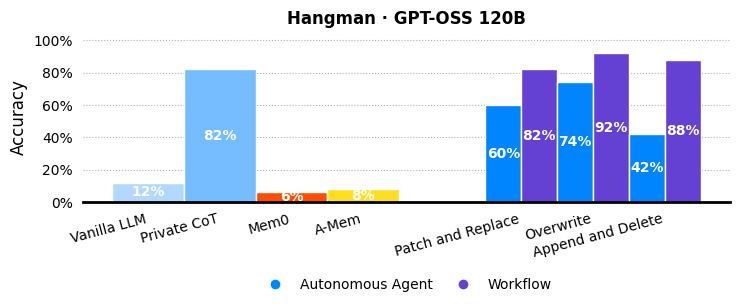

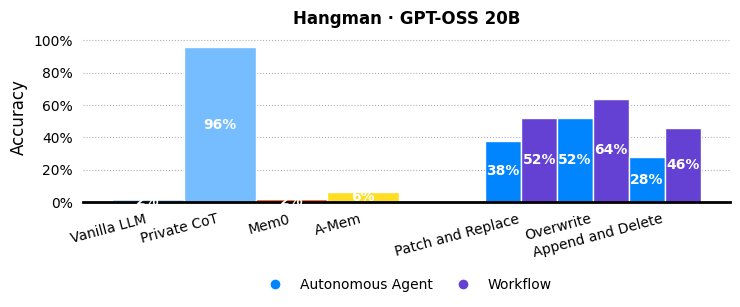

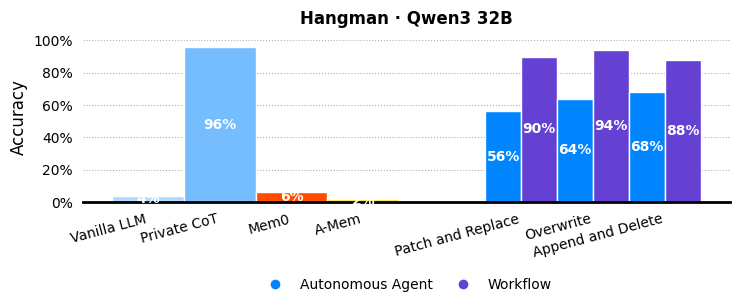

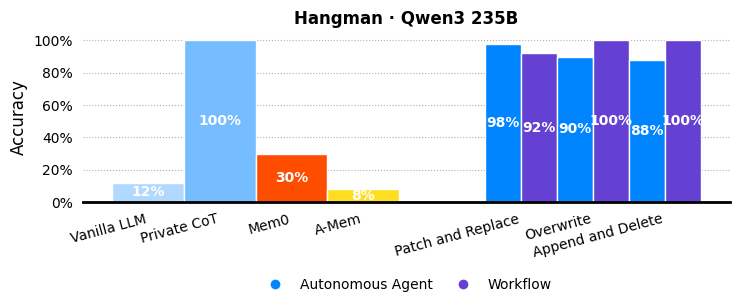

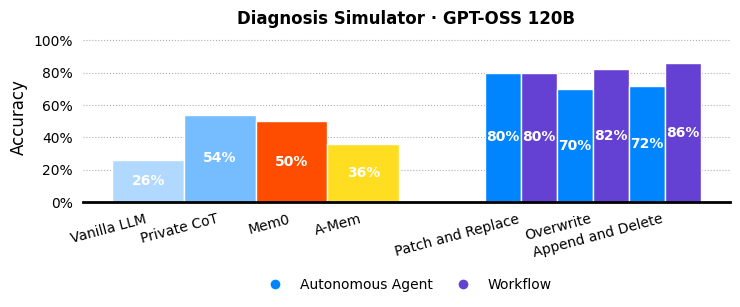

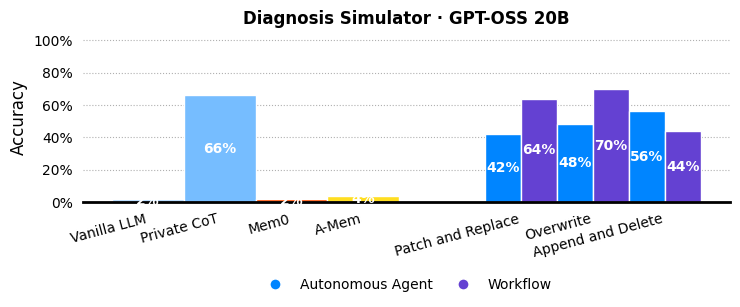

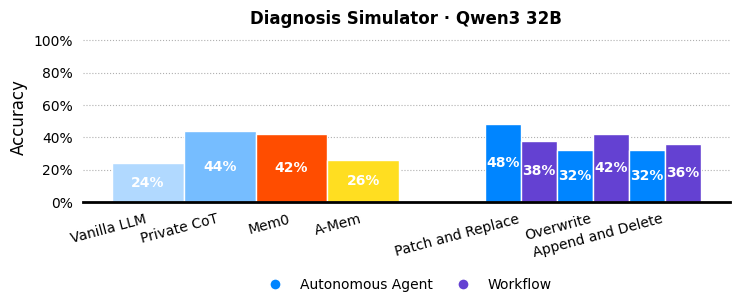

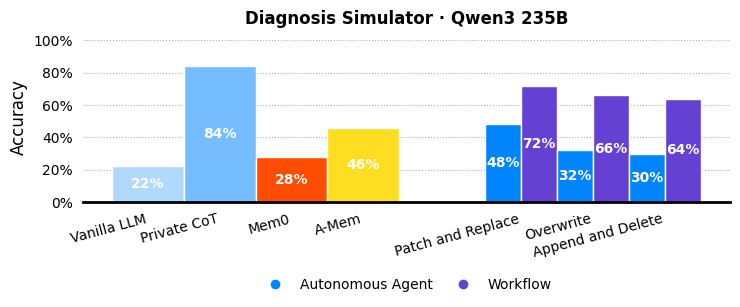

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- Plot ONLY the left plot (accuracy), with explicit 4 baselines ----------
def plot_accuracy_only(
    evaluations: pd.DataFrame,
    figsize=(6.5, 4.0),
    cluster_width=0.8,   # total width allocated to *each column* (controls bar widths)
    gap_columns=1.0,      # visual gap (in column units) between the baseline block and the others
    title="Self-consistency accuracy",
):
    """
    Plots self-consistency accuracy grouped by:
      - Baselines: 4 separate columns (Vanilla LLM, Private CoT, Mem0, A-Mem)
      - Strategy columns: one column per strategy in STRATEGY_ORDER, with bars by family (Autonomous Agent, Workflow)
    Each column (baseline or strategy) gets the same total width (cluster_width).
    X-ticks show baseline names explicitly (no 'Baseline') and strategy names.
    A gap is left only between the baselines block and the rest.
    """

    # --- prepare data (same aggregation as before) ---
    df = evaluations.copy()
    df = df[df["agent"].apply(lambda a: _norm_agent_key(a) in _AGENT_MAP)].copy()
    df["family"]   = df["agent"].map(_agent_family)
    df["strategy"] = df["agent"].map(_agent_strategy)

    g = (
        df.groupby(["model","agent","family","strategy"], as_index=False)["self_consistency"].mean()
          .groupby(["family","strategy"], as_index=False)["self_consistency"].mean()
    )

    baseline_fams_all = ["Vanilla LLM", "Private CoT", "Mem0", "A-Mem"]
    # keep only baselines that are actually present
    baseline_vals = []
    for fam in baseline_fams_all:
        v = g.loc[(g["family"] == fam) & (g["strategy"] == "Baseline"), "self_consistency"]
        if not v.empty:
            baseline_vals.append((fam, float(v.iloc[0])))

    # Strategy columns come from STRATEGY_ORDER; for each, we may have up to 2 families (Autonomous Agent, Workflow)
    strategy_cols = []
    for s in STRATEGY_ORDER:
        fams_here, vals_here = [], []
        for fam in ["Autonomous Agent", "Workflow"]:
            v = g.loc[(g["family"] == fam) & (g["strategy"] == s), "self_consistency"]
            if not v.empty:
                fams_here.append(fam); vals_here.append(float(v.iloc[0]))
        if fams_here:
            strategy_cols.append((s, fams_here, vals_here))

    # --- layout: compute x centers for each column & a gap between blocks ---
    n_baseline_cols = len(baseline_vals)
    n_strategy_cols = len(strategy_cols)

    x_centers_baselines = list(range(n_baseline_cols))
    # add a gap (in "column units") then place strategy columns
    start_strat = (x_centers_baselines[-1] + 1 + gap_columns) if n_baseline_cols > 0 else 0
    x_centers_strats = [start_strat + i for i in range(n_strategy_cols)]

    # x tick labels: explicit baselines (by family name) then strategy names
    xtick_positions = x_centers_baselines + x_centers_strats
    xtick_labels = [fam for fam, _ in baseline_vals] + [s for (s, _, _) in strategy_cols]

    # --- plotting ---
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # Baselines: each is its own column (n=1) so bar width = cluster_width
    for xc, (fam, v) in zip(x_centers_baselines, baseline_vals):
        n = 1
        bar_w = cluster_width / n
        off = 0.0  # single bar centered
        ax.bar(xc + off, v, width=bar_w, color=FAMILY_COLORS[fam], edgecolor="white")

    # Strategy columns: each column may have 1 or 2 families; split cluster_width evenly
    for xc, (s, fams_here, vals_here) in zip(x_centers_strats, strategy_cols):
        n = len(fams_here)
        bar_w = cluster_width / max(n, 1)
        # offsets so that bars are centered within the same total width across all columns
        offs = np.arange(n) * bar_w - (cluster_width - bar_w) / 2.0
        for off, fam, v in zip(offs, fams_here, vals_here):
            ax.bar(xc + off, v, width=bar_w,
                   color=FAMILY_COLORS.get(fam, "#888"), edgecolor="white")

    # Axes cosmetics (unchanged helpers)
    ax.set_xticks(xtick_positions)
    ax.set_xticklabels(xtick_labels, rotation=15, ha="right")
    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
                  labels=["0%","20%","40%","60%","80%","100%"])
    _nice_axes_style(ax, grid_axis="y"); ax.set_ylim(0.0, 1.05)
    _add_value_labels(ax)
    ax.set_title(title, pad=6, fontweight="bold")
    ax.set_ylabel("Accuracy", fontsize=12)

    # ----- Legend (families only; colors) -----
    # Derive present families from evals
    present_fams = []
    fams_from_eval = evaluations["agent"].apply(_agent_family).unique() if "agent" in evaluations.columns else []
    for f in ["Vanilla LLM","Private CoT","Mem0","A-Mem","Autonomous Agent","Workflow"]:
        if f in fams_from_eval:
            present_fams.append(f)

    fam_handles = [
        plt.Line2D([0],[0], marker='o', linestyle='none',
                   markerfacecolor=FAMILY_COLORS[f], markeredgecolor="white",
                   markersize=8, label=f)
        for f in present_fams
    ]

    if fam_handles:
        fam_handles = fam_handles[4:7] 
        ax.legend(fam_handles, [h.get_label() for h in fam_handles],
                  loc="lower center", bbox_to_anchor=(0.5, -0.6),
                  ncol=max(2, len(fam_handles)//2), frameon=False,
                  handletextpad=0.8, columnspacing=1.2)

    plt.tight_layout()
    plt.show()


# --- Usage (same filtering for evaluations; interaction logs not needed here) ---
for game in ["hangman_sct", "diagnosis_simulator_sct"]:
    for model in ["gpt_oss_120b_openrouter", "gpt_oss_20b_openrouter", "qwen3_32b_openrouter", "qwen3_235b_openrouter"]:
        evaluations_sub = evaluations[
            (evaluations["game"] == game) & (evaluations["model"].str.contains(model))
        ]
        plot_accuracy_only(evaluations_sub, figsize=(7.5, 4.0), cluster_width=1, gap_columns=1.2, title=f"{_GAME_NAME[game]} · {_MODEL_NAME[model]}")

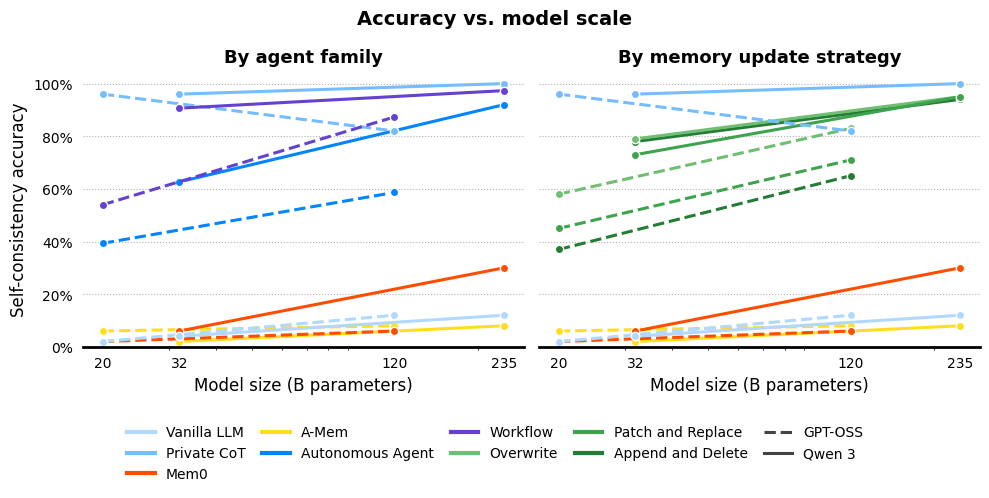

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import re


def _model_family(model: str) -> str:
    m = str(model).lower()
    if "qwen3" in m:   return "Qwen 3"
    if "gpt_oss" in m: return "GPT-OSS"
    return "Other"

def _nice_axes_style(ax, grid_axis="y"):
    ax.tick_params(left=False, bottom=False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    if grid_axis == "y":
        ax.spines["left"].set_visible(False)
        ax.spines["bottom"].set_linewidth(2)
        ax.yaxis.grid(True, which="major", linestyle=":")
    else:
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_linewidth(2)
        ax.xaxis.grid(True, which="major", linestyle=":")
    ax.set_axisbelow(True)

# ---------- LEFT: plot by AGENT FAMILY (colors = FAMILY_COLORS; style = model family) ----------
def _plot_scale_by_family_on_ax(evaluations: pd.DataFrame, ax: plt.Axes,
                                xlog=True, xticks=None):
    df = evaluations.copy()
    if "model_size" not in df.columns:
        df["model_size"] = df["model"].map(_MODEL_SIZE)
    df = df[df["agent"].isin(_AGENT_MAP.keys())].copy()
    df = df[df["model_size"].notna()].copy()
    df["family"] = df["agent"].map(lambda a: _AGENT_MAP[a][0])
    df["model_family"] = df["model"].map(_model_family)

    agg = (df.groupby(["model_family","model_size","family"], as_index=False)["self_consistency"]
             .mean())
    if xticks is None:
        xticks = sorted(agg["model_size"].unique().tolist())

    present_families = set()
    present_model_fams = set()

    for (fam, mf), d in agg.groupby(["family","model_family"]):
        d = d.sort_values("model_size")
        color = FAMILY_COLORS.get(fam, "#888888")
        ls = _MODEL_FAMILY_LS.get(mf, "-.")
        ax.plot(
            d["model_size"], d["self_consistency"],
            linestyle=ls, linewidth=2.2,
            marker="o", markersize=6,
            color=color, markeredgecolor="white",
        )
        present_families.add(fam)
        present_model_fams.add(mf)

    if xlog:
        ax.set_xscale("log", base=10)
        ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.set_xticks(xticks)
    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
                  labels=["0%","20%","40%","60%","80%","100%"])
    ax.set_xlabel("Model size (B parameters)", fontsize=12)
    ax.set_ylabel("Self-consistency accuracy", fontsize=12)
    ax.set_title("By agent family", pad=6, fontsize=13, fontweight="bold")
    _nice_axes_style(ax, grid_axis="y")
    ax.set_ylim(0.0, 1.05)

    return sorted(present_families), sorted(present_model_fams)

# ---------- RIGHT: plot by UPDATE STRATEGY (colors = greens; style = model family) ----------
def _plot_scale_by_strategy_on_ax(evaluations: pd.DataFrame, ax: plt.Axes,
                                  xlog=True, xticks=None):
    df = evaluations.copy()
    if "model_size" not in df.columns:
        df["model_size"] = df["model"].map(_MODEL_SIZE)
    df = df[df["agent"].isin(_AGENT_MAP.keys())].copy()
    df = df[df["model_size"].notna()].copy()

    df["family"] = df["agent"].map(lambda a: _AGENT_MAP[a][0])
    df["strategy"] = df["agent"].map(lambda a: _AGENT_MAP[a][1])
    df["model_family"] = df["model"].map(_model_family)
    # group label: baselines keep family name; others use strategy (averaging Autonomous+Workflow)
    df["group"] = np.where(df["strategy"] == "Baseline", df["family"], df["strategy"])

    agg = (df.groupby(["model_family","model_size","group"], as_index=False)["self_consistency"]
             .mean())

    if xticks is None:
        xticks = sorted(agg["model_size"].unique().tolist())

    def _group_color(g: str) -> str:
        if g in BASELINE_COLORS:
            return BASELINE_COLORS[g]
        return STRATEGY_COLORS.get(g, "#888888")

    present_groups = set()
    present_model_fams = set()

    for (grp, mf), d in agg.groupby(["group","model_family"]):
        d = d.sort_values("model_size")
        color = _group_color(grp)
        ls = _MODEL_FAMILY_LS.get(mf, "-.")
        ax.plot(
            d["model_size"], d["self_consistency"],
            linestyle=ls, linewidth=2.2,
            marker="o", markersize=6,
            color=color, markeredgecolor="white",
        )
        present_groups.add(grp)
        present_model_fams.add(mf)

    if xlog:
        ax.set_xscale("log", base=10)
        ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.set_xticks(xticks)
    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
                  labels=["0%","20%","40%","60%","80%","100%"])
    ax.set_xlabel("Model size (B parameters)", fontsize=12)
    # ax.set_ylabel("Self-consistency accuracy", fontsize=12)
    ax.set_title("By memory update strategy", pad=6, fontsize=13, fontweight="bold")
    _nice_axes_style(ax, grid_axis="y")
    ax.set_ylim(0.0, 1.05)

    return sorted(present_groups), sorted(present_model_fams)

# ---------- COMBINED FIGURE WITH ONE LEGEND AT THE BOTTOM ----------
def plot_scale_family_and_strategy_side_by_side(
    evaluations: pd.DataFrame,
    xlog: bool = True,
    xticks: list | None = None,
    figsize=(10, 5),
):
    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True)

    fams_left,   mfs_left   = _plot_scale_by_family_on_ax(evaluations, axes[0], xlog=xlog, xticks=xticks)
    groups_right, mfs_right = _plot_scale_by_strategy_on_ax(evaluations, axes[1], xlog=xlog, xticks=xticks)

    # ----- Build unified legend (bottom) -----
    # 1) Colors for left families
    fam_handles = []
    fam_labels  = []
    for fam in ["Vanilla LLM", "Private CoT", "Mem0", "A-Mem", "Autonomous Agent", "Workflow"]:
        if fam in fams_left:
            h, = plt.plot([], [], color=FAMILY_COLORS[fam], linewidth=3, label=fam)
            fam_handles.append(h); fam_labels.append(fam)

    # 2) Colors for right groups (baselines + strategies)
    group_order = ["Overwrite", "Patch and Replace", "Append and Delete"]
    group_handles, group_labels = [], []
    def _group_color(g):
        return BASELINE_COLORS.get(g, STRATEGY_COLORS.get(g, "#888888"))
    for g in group_order:
        if g in groups_right:
            h, = plt.plot([], [], color=_group_color(g), linewidth=3, label=g)
            group_handles.append(h); group_labels.append(g)

    # 3) Line-style legend for model families (union of both subplots)
    mf_all = sorted(set(mfs_left) | set(mfs_right))
    mf_handles, mf_labels = [], []
    for mf in mf_all:
        ls = _MODEL_FAMILY_LS.get(mf, "-.")
        h, = plt.plot([], [], color="#444444", linestyle=ls, linewidth=2.2, label=mf)
        mf_handles.append(h); mf_labels.append(mf)

    # Optional headers (non-drawing) to separate sections
    header_left   = plt.Line2D([], [], linestyle='none', label="Left: Agent families")
    header_right  = plt.Line2D([], [], linestyle='none', label="Right: Baselines & strategies")
    header_styles = plt.Line2D([], [], linestyle='none', label="Line styles: Model families")

    # handles = [header_left] + fam_handles + [header_right] + group_handles + [header_styles] + mf_handles
    handles = fam_handles + group_handles + mf_handles
    labels  = [h.get_label() for h in handles]

    fig.suptitle("Accuracy vs. model scale", fontsize=14, fontweight="bold")

    # Layout: make room at the bottom
    plt.tight_layout(rect=[0, 0.18, 1, 1])
    fig.legend(handles, labels, loc="lower center",
               ncol=max(4, len(handles)//2),
               frameon=False, borderaxespad=0.8, handletextpad=0.8, columnspacing=1.2)

    plt.show()

# --- Usage ---
evaluations_sub = evaluations[(evaluations["game"] == "hangman_sct") & (evaluations["model"].str.contains(""))]
# evaluations_sub = evaluations[(evaluations["game"] == "hangman_sct") & (evaluations["model"] == "gpt_oss_20b_openrouter")]
plot_scale_family_and_strategy_side_by_side(evaluations_sub, xlog=True)

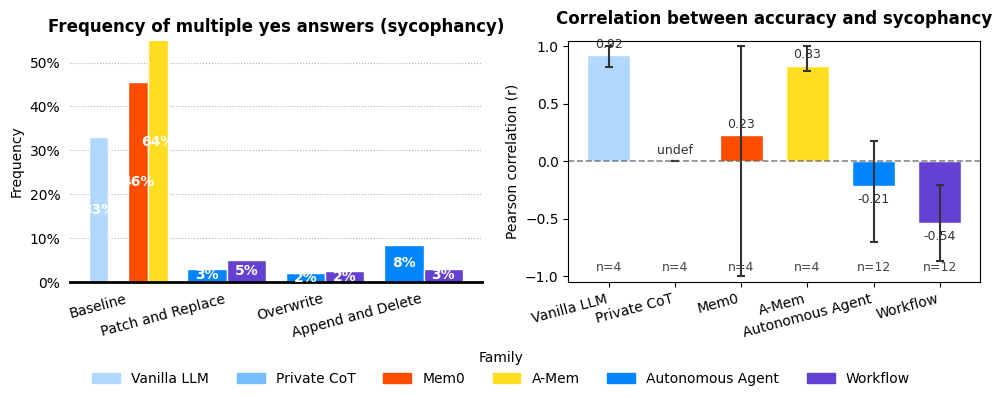

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# (reuse your palettes, FAMILY_COLORS, STRATEGY_ORDER, _AGENT_MAP, _nice_axes_style, _add_value_labels from your snippets)

def plot_sycophancy_and_correlation(evaluations: pd.DataFrame, invert: bool = True,
                                    n_boot: int = 5000, seed: int = 0):
    """
    Create a side-by-side figure:
      Left: Selectivity/Sycophancy grouped bar plot.
      Right: Correlation between accuracy and sycophancy (Pearson r with 95% CI).
    """

    # ---------------- LEFT PANEL (sycophancy/selectivity) ----------------
    df = evaluations.copy()
    df = df[df["agent"].isin(_AGENT_MAP.keys())].copy()
    df["family"] = df["agent"].map(lambda a: _AGENT_MAP[a][0])
    df["strategy"] = df["agent"].map(lambda a: _AGENT_MAP[a][1])

    metric = "more_than_one_yes"
    g = (
        df.groupby(["model", "agent", "family", "strategy"], as_index=False)[metric]
          .mean()
          .groupby(["family", "strategy"], as_index=False)[metric]
          .mean()
    )

    if invert:
        g["value"] = 1.0 - g[metric]
        left_title = "Selectivity (1 − fraction of trials with >1 'yes')"
        left_ylabel = "Selectivity (higher is better)"
    else:
        g["value"] = g[metric]
        left_title = "Frequency of multiple yes answers (sycophancy)"
        left_ylabel = "Frequency"

    clusters = ["Baseline"] + STRATEGY_ORDER
    x_pos = {name: i for i, name in enumerate(clusters)}

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    # --- Baseline cluster
    baseline_fams = ["Vanilla LLM", "Private CoT", "Mem0", "A-Mem"]
    base_vals = []
    for fam in baseline_fams:
        v = g.loc[(g["family"] == fam) & (g["strategy"] == "Baseline"), "value"]
        if not v.empty:
            base_vals.append((fam, float(v.iloc[0])))

    if base_vals:
        n = len(base_vals)
        cluster_width = 0.8
        bar_w = cluster_width / n
        offsets = np.arange(n) * bar_w - (cluster_width - bar_w) / 2.0
        for (off, (fam, v)) in zip(offsets, base_vals):
            ax1.bar(
                x_pos["Baseline"] + off,
                v,
                width=bar_w,
                color=FAMILY_COLORS[fam],
                edgecolor="white",
                label=fam,
            )

    # --- Strategy clusters
    for s in STRATEGY_ORDER:
        fams_here, vals_here = [], []
        for fam in ["Autonomous Agent", "Workflow"]:
            v = g.loc[(g["family"] == fam) & (g["strategy"] == s), "value"]
            if not v.empty:
                fams_here.append(fam)
                vals_here.append(float(v.iloc[0]))
        if not fams_here:
            continue
        n = len(fams_here)
        cluster_width = 0.8
        bar_w = cluster_width / n
        offsets = np.arange(n) * bar_w - (cluster_width - bar_w) / 2.0
        for off, fam, v in zip(offsets, fams_here, vals_here):
            ax1.bar(
                x_pos[s] + off,
                v,
                width=bar_w,
                color=FAMILY_COLORS[fam],
                edgecolor="white",
                label=fam,
            )

    ax1.set_xticks([x_pos[name] for name in clusters])
    ax1.set_xticklabels(clusters, rotation=15, ha="right")
    ax1.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5], labels=["0%", "10%", "20%", "30%", "40%", "50%",])
    _nice_axes_style(ax1, grid_axis="y")
    ax1.set_ylim(0.0, 0.55)
    _add_value_labels(ax1)
    ax1.set_title(left_title, pad=6, fontweight="bold")
    ax1.set_ylabel(left_ylabel)

    # ---------------- RIGHT PANEL (correlation) ----------------
    needed = {"model","agent","revealed_yes","more_than_one_yes"}
    if not needed.issubset(evaluations.columns):
        raise ValueError(f"Missing required columns: {needed - set(evaluations.columns)}")

    df = evaluations[evaluations["agent"].isin(_AGENT_MAP.keys())].copy()
    df["family"] = df["agent"].map(lambda a: _AGENT_MAP[a][0])

    pts = (df.groupby(["family","agent","model"], as_index=False)
             .agg(revealed_yes=("revealed_yes","mean"),
                  more_than_one_yes=("more_than_one_yes","mean")))

    rng = np.random.default_rng(seed)
    rows = []
    for fam, d in pts.groupby("family"):
        x = d["revealed_yes"].to_numpy()
        y = d["more_than_one_yes"].to_numpy()
        if len(x) < 2 or np.std(x) == 0 or np.std(y) == 0:
            r, lo, hi, is_nan = np.nan, np.nan, np.nan, True
        else:
            r, _ = pearsonr(x, y)
            n = len(d)
            boot = []
            if n >= 3:
                for _ in range(n_boot):
                    idx = rng.integers(0, n, size=n)
                    xb, yb = x[idx], y[idx]
                    if np.std(xb) > 0 and np.std(yb) > 0:
                        rb, _ = pearsonr(xb, yb)
                        boot.append(rb)
            if boot:
                lo, hi = np.percentile(boot, [2.5, 97.5])
            else:
                lo, hi = np.nan, np.nan
            is_nan = False
        rows.append({"family": fam, "r": r, "lo": lo, "hi": hi,
                     "is_nan": is_nan, "n_points": len(d)})

    corr_df = pd.DataFrame(rows)
    fam_order = ["Vanilla LLM", "Private CoT", "Mem0", "A-Mem", "Autonomous Agent", "Workflow"]
    corr_df = corr_df.set_index("family").reindex(fam_order).reset_index()

    corr_df["r_plot"]  = corr_df["r"].fillna(0.0)
    corr_df["lo_plot"] = np.where(corr_df["is_nan"], corr_df["r_plot"], corr_df["lo"])
    corr_df["hi_plot"] = np.where(corr_df["is_nan"], corr_df["r_plot"], corr_df["hi"])

    x = np.arange(len(corr_df))
    for i, row in corr_df.iterrows():
        fam   = row["family"]
        color = FAMILY_COLORS.get(fam, "#888888")
        ax2.bar(
            x[i], row["r_plot"],
            color=color, edgecolor="white", width=0.65,
            hatch="///" if row["is_nan"] else None,
            alpha=0.55 if row["is_nan"] else 1.0,
        )
        label_txt = "undef" if row["is_nan"] else f"{row['r_plot']:.2f}"
        ax2.text(x[i], row["r_plot"] + (0.04 if row["r_plot"] >= 0 else -0.06),
                 label_txt, ha="center", va="bottom" if row["r_plot"]>=0 else "top",
                 fontsize=9, color="#333333")

    vals = corr_df["r_plot"].to_numpy()
    yerr = np.vstack([
        np.where(corr_df["is_nan"], 0.0, vals - corr_df["lo_plot"].to_numpy()),
        np.where(corr_df["is_nan"], 0.0, corr_df["hi_plot"].to_numpy() - vals),
    ])
    ax2.errorbar(x, vals, yerr=yerr, fmt="none", ecolor="#333333",
                 elinewidth=1.5, capsize=3, capthick=1.5)

    ax2.axhline(0, color="#555555", linewidth=1.2, linestyle="--", alpha=0.7)
    ax2.set_xticks(x)
    ax2.set_xticklabels(corr_df["family"], rotation=15, ha="right")
    ax2.set_ylabel("Pearson correlation (r)")
    ax2.set_title("Correlation between accuracy and sycophancy", fontweight="bold", pad=12)
    # _nice_axes_style(ax2, grid_axis="y")
    ax2.set_ylim(-1.05, 1.05)

    for i, n in enumerate(corr_df["n_points"].to_numpy()):
        ax2.text(x[i], -0.98, f"n={int(n)}", ha="center", va="bottom", fontsize=9, color="#444444")

    # ---------------- Shared legend ----------------
    handles = [plt.Rectangle((0,0),1,1,color=FAMILY_COLORS[f]) for f in fam_order]
    labels  = fam_order
    fig.legend(handles, labels, loc="lower center", ncol=len(fam_order), frameon=False, title="Family")

    # plt.tight_layout(rect=[0,0,1.2,0.92])
    plt.tight_layout(rect=[0, 0.1, 1, 1])
    # plt.tight_layout(rect=[0,0,0.92,1])
    plt.show()

# Example usage:
# evaluations_sub = evaluations[evaluations["game"] == "diagnosis_simulator_sct"]
# evaluations_sub = evaluations[(evaluations["game"] == "hangman_sct") & (evaluations["model"] == "gpt_oss_20b_openrouter")]
evaluations_sub = evaluations[(evaluations["game"] == "hangman_sct") & (evaluations["model"].str.contains(""))]
plot_sycophancy_and_correlation(evaluations_sub, invert=False, n_boot=5000, seed=0)

In [36]:
evaluations.game.value_counts()

game
diagnosis_simulator_sct    2055
hangman_sct                2050
Name: count, dtype: int64

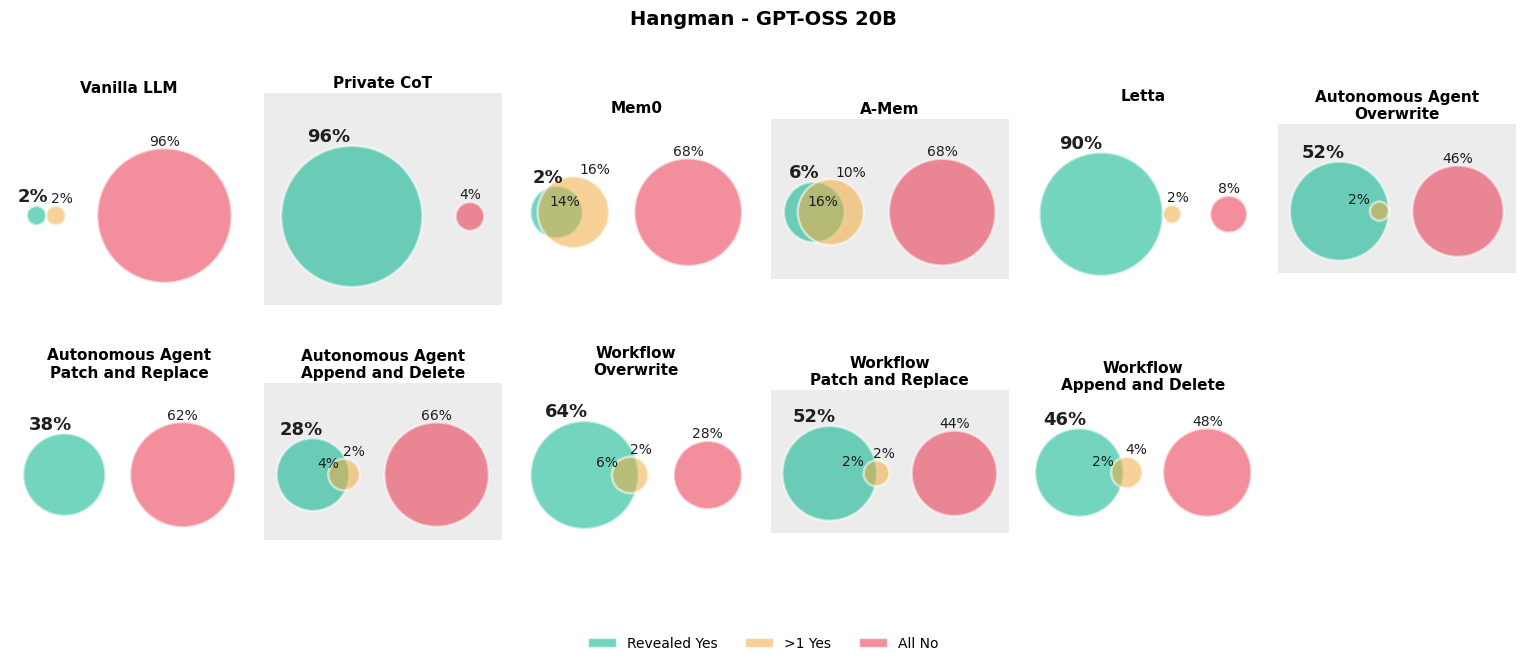

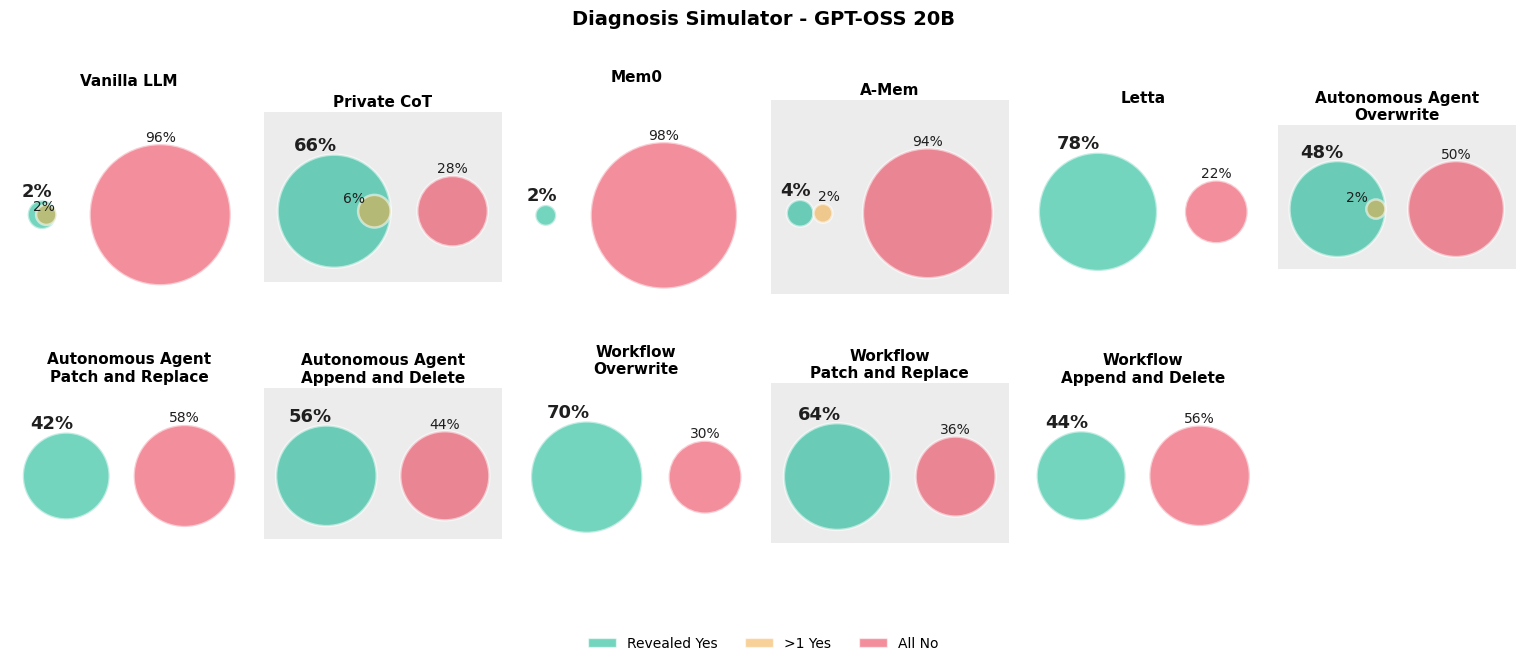

In [39]:
###########
## Final Cell — 3-Circle Venns per agent (2x5) ##
###########
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Patch

BG_COLORS = ["#ffffff", "#ececec"]


# Pretty title per agent: Family + (newline Strategy if not Baseline)
def _pretty_title(agent: str) -> str:
    fam, strat = _AGENT_MAP[agent]
    return fam if strat == "Baseline" else f"{fam}\n{strat}"

# Choose colors: one per circle/zone
VENN_COLORS = {
    "Revealed Yes": "#00b38a",        
    "More than one Yes": "#f2ac42",       
    "All No": "#ea324c",            
}

def _pct(x: float) -> float:
    return max(0.0, float(x))

def _solve_distance_for_overlap(r1, r2, target_overlap, tol=1e-5, maxit=60):
    """
    Given radii r1, r2 and desired intersection area, find center distance d
    so that the overlap area between two circles equals target_overlap.
    Assumes 0 <= target_overlap <= π * min(r1, r2)^2.
    Uses binary search on d in [abs(r1 - r2), r1 + r2].
    """
    if target_overlap <= 0:
        return r1 + r2 + 1e-6  # no overlap
    max_overlap = np.pi * min(r1, r2)**2
    if target_overlap >= max_overlap - 1e-12:
        return abs(r1 - r2)    # one contained in the other

    def overlap_area(d):
        # Standard two-circle overlap formula
        if d >= r1 + r2:
            return 0.0
        if d <= abs(r1 - r2):
            return np.pi * min(r1, r2)**2
        alpha = 2 * np.arccos((d**2 + r1**2 - r2**2) / (2 * d * r1))
        beta  = 2 * np.arccos((d**2 + r2**2 - r1**2) / (2 * d * r2))
        area = 0.5 * r1**2 * (alpha - np.sin(alpha)) + 0.5 * r2**2 * (beta - np.sin(beta))
        return area

    lo, hi = abs(r1 - r2), r1 + r2
    for _ in range(maxit):
        mid = 0.5 * (lo + hi)
        a = overlap_area(mid)
        if abs(a - target_overlap) < tol:
            return mid
        if a > target_overlap:
            lo = mid
        else:
            hi = mid
    return 0.5 * (lo + hi)

def _draw_single_venn(ax, pA, pB, pAB, title, colors=VENN_COLORS, bg_color="#ffffff"):
    """
    Draw one 3-circle Venn:
      - Circle A: Revealed Yes
      - Circle B: >1 Yes
      - Circle C: All No (disjoint)
    Areas proportional to percentages. Intersection only between A and B.
    """
    # Clamp and derive zone percentages
    pA = _pct(pA); pB = _pct(pB); pAB = _pct(min(pAB, min(pA, pB)))
    onlyA = _pct(pA - pAB)
    onlyB = _pct(pB - pAB)
    allNo = _pct(1.0 - pA - pB + pAB)

    # Scale factor: convert probability to area by A = k * p
    # Choose k so that largest radius fits nicely in the panel
    base_radius_target = 0.32  # radius ~ 0.32 of axis span for the largest circle
    max_p = max(pA, pB, allNo, 1e-6)
    k = (np.pi * base_radius_target**2) / max_p

    # Radii from areas
    rA = np.sqrt(k * pA / np.pi) if pA > 0 else 0.0
    rB = np.sqrt(k * pB / np.pi) if pB > 0 else 0.0
    rC = np.sqrt(k * allNo / np.pi) if allNo > 0 else 0.0

    # Solve distance between A and B to match intersection
    target_overlap = k * pAB  # convert probability to area
    if rA > 0 and rB > 0:
        dAB = _solve_distance_for_overlap(rA, rB, target_overlap)
    else:
        dAB = (rA + rB) + 1e-6

    # Place A at (0, 0), B at (dAB, 0); place C disjoint to the right of both
    xA, yA = 0.0, 0.0
    xB, yB = dAB, 0.0
    # Put C far enough to be disjoint from both A and B
    sep = 0.15
    x_right_edge = max(xA + rA, xB + rB)
    xC = x_right_edge + (sep + rC)
    yC = 0.0

    # Normalize view window around the three circles
    x_min = min(xA - rA, xB - rB, xC - rC) - 0.08
    x_max = max(xA + rA, xB + rB, xC + rC) + 0.08
    y_min = min(yA - rA, yB - rB, yC - rC) - 0.08
    y_max = max(yA + rA, yB + rB, yC + rC) + 0.24  # extra top room for labels

    # Draw circles (white edges)
    if rA > 0:
        ax.add_patch(Circle((xA, yA), rA, facecolor=colors["Revealed Yes"], alpha=0.55,
                            edgecolor="white", linewidth=1.8))
    if rB > 0:
        ax.add_patch(Circle((xB, yB), rB, facecolor=colors["More than one Yes"], alpha=0.55,
                            edgecolor="white", linewidth=1.8))
    if rC > 0:
        ax.add_patch(Circle((xC, yC), rC, facecolor=colors["All No"], alpha=0.55,
                            edgecolor="white", linewidth=1.8))

    # Place percentage labels (non-zero only), on top of their regions
    def fmt(p): return f"{100.0*p:.0f}%"

    # A-only label: nudge left if there is substantial overlap
    if onlyA > 0 and rA > 0:
        ax.text(xA - (0.33 * rA),
                yA + 1 * rA,
                fmt(onlyA), ha="center", va="bottom", fontsize=13, color="#1f1f1f", weight="bold")

    # B-only label
    if onlyB > 0 and rB > 0:
        ax.text(xB + (0.6 * rB),
                yB + 1 * rB,
                fmt(onlyB), ha="center", va="bottom", fontsize=10, color="#1f1f1f")

    # Intersection label at midpoint between centers (up a bit)
    if pAB > 0 and rA > 0 and rB > 0:
        xm, ym = (xA + xB) / 2.0, (yA + yB) / 2.0
        ax.text(xm, ym + 0.1 * max(rA, rB),
                fmt(pAB), ha="center", va="bottom", fontsize=10, color="#1f1f1f")

    # All-No label
    if allNo > 0 and rC > 0:
        ax.text(xC, yC + 1 * rC,
                fmt(allNo), ha="center", va="bottom", fontsize=10, color="#1f1f1f")

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_aspect("equal", adjustable="box")
    # ax.axis("off")
    ax.set_title(title, fontsize=11, fontweight="bold", pad=4)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_facecolor(bg_color)

def plot_venns(evaluations_sub, suptitle: str):
    # ---- Aggregate percentages per agent from evaluations_sub ----
    # Keep only agents we know and that appear in the filtered data
    agents_in_data = sorted(set(evaluations_sub["agent"]).intersection(_AGENT_MAP.keys()),
                            key=lambda a: (_AGENT_MAP[a][0], _AGENT_MAP[a][1], a))

    # If you want to force a fixed order (the 10 agents), use:
    ALL_AGENTS = list(_AGENT_MAP.keys())
    agents = [a for a in ALL_AGENTS if a in agents_in_data]

    rows = []
    for a in agents:
        df = evaluations_sub[evaluations_sub["agent"] == a]
        if len(df) == 0:
            continue
        # Probabilities as means over trials
        pA  = float((df["revealed_yes"] == True).mean())
        pB  = float((df["more_than_one_yes"] == True).mean())
        pAB = float(((df["revealed_yes"] == True) & (df["more_than_one_yes"] == True)).mean())
        rows.append({"agent": a, "pA": pA, "pB": pB, "pAB": pAB})

    agg = pd.DataFrame(rows)

    # ---- Create 2x5 grid ----
    n = len(agg)
    ncols = 6
    nrows = 2
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 6.6))
    axes = np.array(axes).reshape(nrows, ncols)

    # Draw each Venn; blank any unused panels
    for idx in range(nrows * ncols):
        r = idx // ncols
        c = idx % ncols
        ax = axes[r, c]
        if idx < n:
            row = agg.iloc[idx]
            title = _pretty_title(row["agent"])
            _draw_single_venn(ax, row["pA"], row["pB"], row["pAB"], title, bg_color=BG_COLORS[idx % len(BG_COLORS)])
        else:
            ax.axis("off")

    # ---- Single legend for the full figure ----
    legend_handles = [
        Patch(facecolor=VENN_COLORS["Revealed Yes"], edgecolor="white", label="Revealed Yes", alpha=0.55),
        Patch(facecolor=VENN_COLORS["More than one Yes"], edgecolor="white", label=">1 Yes", alpha=0.55),
        Patch(facecolor=VENN_COLORS["All No"], edgecolor="white", label="All No", alpha=0.55),
    ]
    fig.legend(legend_handles, [h.get_label() for h in legend_handles],
            loc="lower center", ncol=3, frameon=False, bbox_to_anchor=(0.5, -0.01))
    
    if suptitle:
        plt.suptitle(suptitle, fontsize=14, fontweight="bold")

    plt.tight_layout(rect=[0.02, 0.04, 0.98, 1.0])
    plt.show()

game = "hangman_sct"
model = "gpt_oss_120b_openrouter"
evaluations_sub = evaluations[(evaluations["game"] == game) & (evaluations["model"] == model)]

for game in ["hangman_sct", "diagnosis_simulator_sct"]:
    # for model in ["gpt_oss_120b_openrouter", "gpt_oss_20b_openrouter", "qwen3_32b_openrouter", "qwen3_235b_openrouter"]:
    for model in ["gpt_oss_20b_openrouter"]:
        evaluations_sub = evaluations[(evaluations["game"] == game) & (evaluations["model"] == model)]
        plot_venns(evaluations_sub, suptitle=f"{_GAME_NAME[game]} - {_MODEL_NAME[model]}")